# Big Data Coursework - Brief

## Data Processing and Machine Learning in the Cloud 

This is the **INM432 Big Data coursework 2022**. 
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks include parallelization in PySpark, extension, evaluation, and theoretical reflection. 
Please complete and submit the **coding tasks** in a copy of **this notebook**. 
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**. 

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google Cloud provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis. 

## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**). 

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  




## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras. 
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner. 
What we will do here is **parallelise** **pre-processing**, **measuring** and **machine learning** in the cloud and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**. 

This coursework contains *5 sections**. 

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments). 

### Section 1 
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes). 
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like. 

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package. 
There is no task for you here, but you will need to re-use some of this code later. 

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc. 
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud. 

### Section 2 
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

In Section 3, we will **use the pre-processed data in Tensorflow/Keras**. 
We will use the GC **AI-Platform** (formerly Cloud ML) in **Task 3** and **test different parallelisation approaches for multiple GPUs**. 

### Section 4

This section is about the theoretical discussion, based on to two papers, in **Task 4**. The answers should be given in the PDF report. 

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis. 

The **tasks** are **mostly independent**. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

You need to run the **imports and authentication every time you work with this notebook**. 
Use the **local Spark** installation for development before you send jobs to the cloud. 

Read through this section once and **fill in the project ID the first time**, then you can just run straight throught this at the beginning of each session - except for the two authentication cells. 

### Imports

We import some **packages that will be needed throughout**. 
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below. 


In [1]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.8.0


### Cloud and Drive authentication

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work. 

In [2]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [3]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit. 
This way we don't have to specify this information every time we access the cloud.  

In [70]:

PROJECT = 'bdvk210033252'  ### USE YOUR PROJECT ID HERE. ### 
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION    

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = vivekkanna.j@gmail.com
project = bdvk210033252
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**. 
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems. 
**You must create your own bucket to have write access.**

In [71]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://bdvk210033252-storage/...
ServiceException: 409 A Cloud Storage bucket named 'bdvk210033252-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [72]:
#@title Utility functions for image display [RUN THIS TO ACTIVATE] { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  

### Install Spark locally for quick testing 

You can use the cell below to **install Spark locally on this Colab VM** as in the labs, to do quicker small-scale interactive testing. Using the spark in the cloud with dataproc is still required for the final version. 

We are using not the up-to date version of Spark. This is  because restrictions in the Google Cloud free tier make it preferable to use the old version there. 

In [73]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-2.4.8-bin-hadoop2.7.tgz" # unpack 

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.2.1-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/root/spark-2.4.8-bin-hadoop2.7"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
2.4.8
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning with Keras/Tensorflow. 
The tasks are about **parallelisation** and **analysis** the performance of the cloud services. 

## 1.1 Getting started 

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

This code is based on using the TensorFlow `tf.data` package, which offers mechanisms for map functions. Your task will be to apply the same approach   


We start by **setting some variables for the *Flowers* dataset**.

In [74]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset. 
**TensorFlow** class has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we can deal with parts of images).

In [75]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed). 
Below are **map functions** for these steps. 
You **don't need to study** about the **internals of these functions** in detail. 

In [76]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

In [77]:
filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dataset1 = filepathDS.map(decode_jpeg_and_label)
for x in dataset1.take(1):
    print(x) # show what's in a data item

(<tf.Tensor: shape=(333, 500, 3), dtype=uint8, numpy=
array([[[152, 118,  80],
        [152, 118,  80],
        [151, 119,  78],
        ...,
        [132, 103,  71],
        [118,  89,  57],
        [117,  88,  56]],

       [[155, 121,  83],
        [155, 121,  83],
        [153, 121,  80],
        ...,
        [120,  89,  58],
        [124,  94,  60],
        [120,  90,  56]],

       [[149, 115,  77],
        [151, 117,  79],
        [155, 123,  82],
        ...,
        [135, 102,  69],
        [137, 104,  71],
        [128,  95,  62]],

       ...,

       [[173, 131,  81],
        [149, 110,  69],
        [132,  97,  57],
        ...,
        [ 70,  49,  30],
        [ 64,  43,  24],
        [ 88,  61,  42]],

       [[144, 101,  59],
        [135,  92,  57],
        [165, 127,  90],
        ...,
        [ 77,  58,  41],
        [ 57,  38,  21],
        [ 78,  52,  35]],

       [[160, 116,  81],
        [148, 105,  71],
        [167, 128,  87],
        ...,
        [ 62,  45,  

With `tf.data`  we can apply the decoding and resizing functions on the fly and try reading from the dataset.

In [78]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)  

We can also look at some images using the image display function defined above (the one with the hidden code).

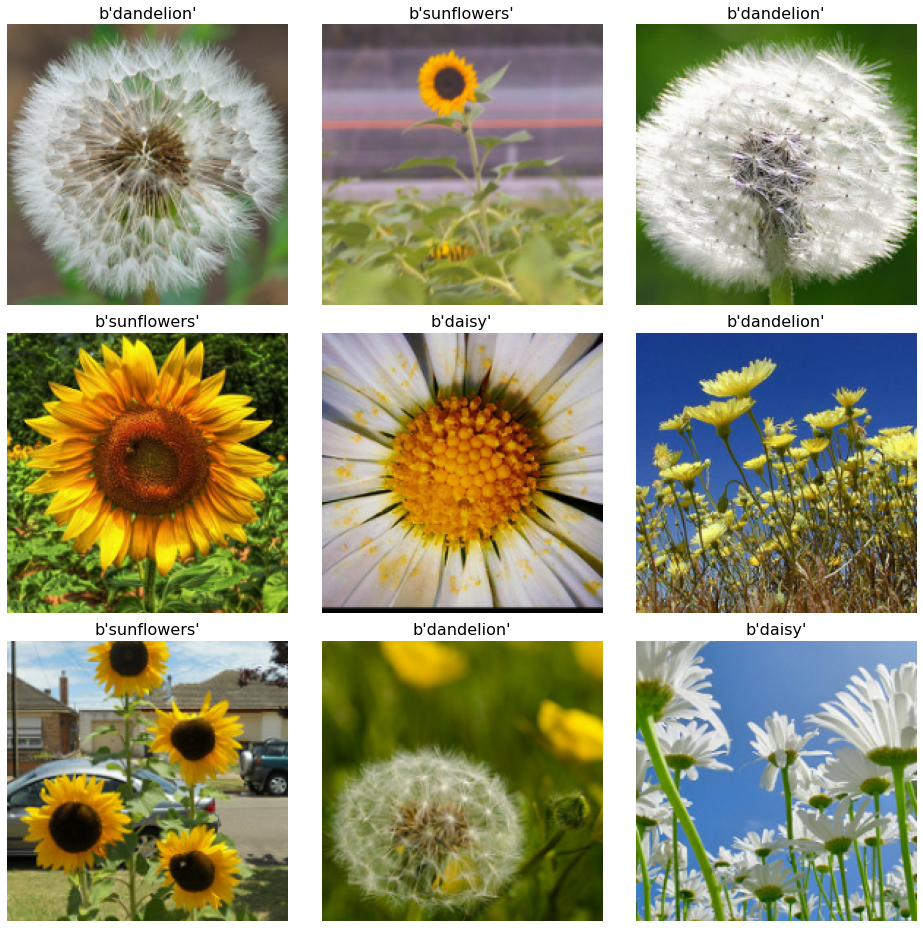

In [79]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [80]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['roses', 'dandelion', 'dandelion', 'sunflowers', 'tulips', 'sunflowers', 'tulips', 'roses', 'dandelion', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'tulips', 'tulips', 'daisy', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'daisy', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'daisy', 'dandelion', 'sunflowers', 'sunflowers', 'sunflowers', 'roses', 'tulips', 'dandelion', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['tulips', 'roses', 'roses', 'sunflowers', 'dandelion', 'roses', 'dandelion', 'tulips', 'tulips', 'daisy'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'sunflowers', 'roses', 'tulips', 'daisy', 'roses', 'sunflowers', 'roses', 'dandelion', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'roses', 'roses', 'tulips', 'tulips', 'tulips', 'tulips', 'sunflowers', 'dandelion', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['daisy', 'daisy', 'sunflowers', 'tulips', '

## 1.2 Improving Speed 

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size. 
This **costs some CPU time**, but **saves network and disk bandwith**, especially when the data are **read multiple times**. 


In [81]:
# This is a quick test to get an idea how long recompressions takes.  
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()])) 

Image batch shape (10,), ['sunflowers', 'tulips', 'dandelion', 'daisy', 'daisy', 'tulips', 'tulips', 'daisy', 'tulips', 'sunflowers'])
Image batch shape (10,), ['daisy', 'dandelion', 'dandelion', 'dandelion', 'tulips', 'daisy', 'dandelion', 'sunflowers', 'roses', 'daisy'])
Image batch shape (10,), ['tulips', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'tulips', 'roses'])
Image batch shape (10,), ['roses', 'tulips', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'tulips', 'daisy'])
Image batch shape (10,), ['dandelion', 'sunflowers', 'tulips', 'dandelion', 'roses', 'daisy', 'roses', 'roses', 'sunflowers', 'roses'])
Image batch shape (10,), ['tulips', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'daisy', 'sunflowers', 'dandelion', 'tulips', 'sunflowers'])
Image batch shape (10,), ['tulips', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'roses', 'dandelion', 'sunflowers', 'dandelion', 'tulips'])
Image batch shap

In [82]:
dataset4

<MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains. 
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used. 
First we need to **define a location** where we want to put the file. 

In [83]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket. 

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later.Again, you don't need to study the first three functions' internals, only the `write_tfrecord` function is relevant.  

There are **ready-made pre-processed data** versions available, e.g. here: 
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for comparison and later use. 

In [84]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size):
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)  
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file 
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files  
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

Writing TFRecords
Wrote file gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers08-230.tfrec containing 230 records
Wrote file gs://bdvk21003325

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above. These functions are for demonstration only, you don't need to study these.

In [85]:
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**. 

In [86]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '1', '1', '1', '1', '1'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '1', '1', '1', '1', '2', '2', '2'])
Image batch shape (10, 192, 192, 3), ['2', '2', '2', '2', '2', '2', '2', '2', '0', '4'])
Image batch shape (10, 192, 192, 3), ['0', '1', '2', '4', '1', '0', '2', '2', '1', '3'])
Image batch shape (10, 192, 192, 3), ['3', '4', '0', '2', '4', '0', '3', '1', '3', '2'])
Image batch shape (10, 192, 192, 3), ['3', '0', '2', '2', '4', '1', '3', '2', '1', '2'])
Image batch shape (10, 192, 192, 3), ['3', '4', '1', '0', '2', '3', '0', '1', '2', '2'])
Image batch shape (10, 192, 192, 3), ['3', '1', '3', '2', '2', '4', '1', '1', '0', '4'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (30%)

Since recompressing and repackaging is effective, we would like to be able to do it inparallel for large datasets. 
This is a relatively straightforward case of parallelisation. 
We will use Spark to implement the same process as above, but in parallel.

### 1a)	Create the script (10%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**. 

You need to: 

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression function **to Spark** (only one argument). (2%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (2%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files, using an RDD as the vehicle for parallelisation but not for storing the image data. (2%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function. 
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (3%) 


In [87]:
# In task 1 the mapping function from above are resued again to adapt for the resizing and for using the recompression fuctions to spark using only one argument in this case. 

In [88]:
### CODING TASK

### Part 1
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

   
def resize_and_crop_image(RDD):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    image, label = RDD
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label


def recompress_image(RDD):
    # this reduces the amount of data, but takes some time
    image, label = RDD
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label



In [89]:
## Task 2 we used the sc parallelize function to TensorFlow Dataset objects with RDDs

### Part 2
imageRDD = sc.parallelize(dsetFiles)

In [90]:
### Task 3 we Sample the  RDD to a smaller number tusing the sampling factor of 0.02 for short tests at an appropriate position in the code.

### Part 3 ###
sampledRDD = imageRDD.sample(False, 0.02)

In [91]:
### Task 4 The functions from above  are used to write the TFRecord filesby the usage of an RDD as a pipeline for the arallelisation 

### Part 4 ###
decodedRDD = sampledRDD.map(decode_jpeg_and_label)
resizedRDD = decodedRDD.map(resize_and_crop_image)  
recompressedRDD = resizedRDD.map(recompress_image)  

In [92]:
###  TFRecord files is created as a function.
### Every partition is applied with a TFrecord function with the 'RDD.mapPartitionsWithIndex' function. 
### The file name is returned

### Part 5 ###

def write_tfrecord(index,partition):
  filename = GCS_OUTPUT + "{}.tfrec".format(index)
  with tf.io.TFRecordWriter(filename) as out_file:
    for element in partition:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), # re-compressed image: already a byte string
                            label.numpy() #, height.numpy()[i], width.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
  yield (filename)




In [93]:
recompressedRDD.mapPartitionsWithIndex(write_tfrecord).collect()

['gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers0.tfrec',
 'gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers1.tfrec',
 'gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers2.tfrec',
 'gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers3.tfrec']

In [94]:
filenames_convert_to_rdd_collect = recompressedRDD.mapPartitionsWithIndex(write_tfrecord).collect()

In [95]:
### Checking for the filenames

(filenames_convert_to_rdd_collect)

['gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers0.tfrec',
 'gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers1.tfrec',
 'gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers2.tfrec',
 'gs://bdvk210033252-storage/tfrecords-jpeg-192x192-2/flowers3.tfrec']

### 1b)	Testing (2%)

i) Read from the TFRecord Dataset, using `display_9_images_from_dataset` to test. 


In [96]:
### Using the display 9 images function we load and read the TFrecord data set to display 9 images 

def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  

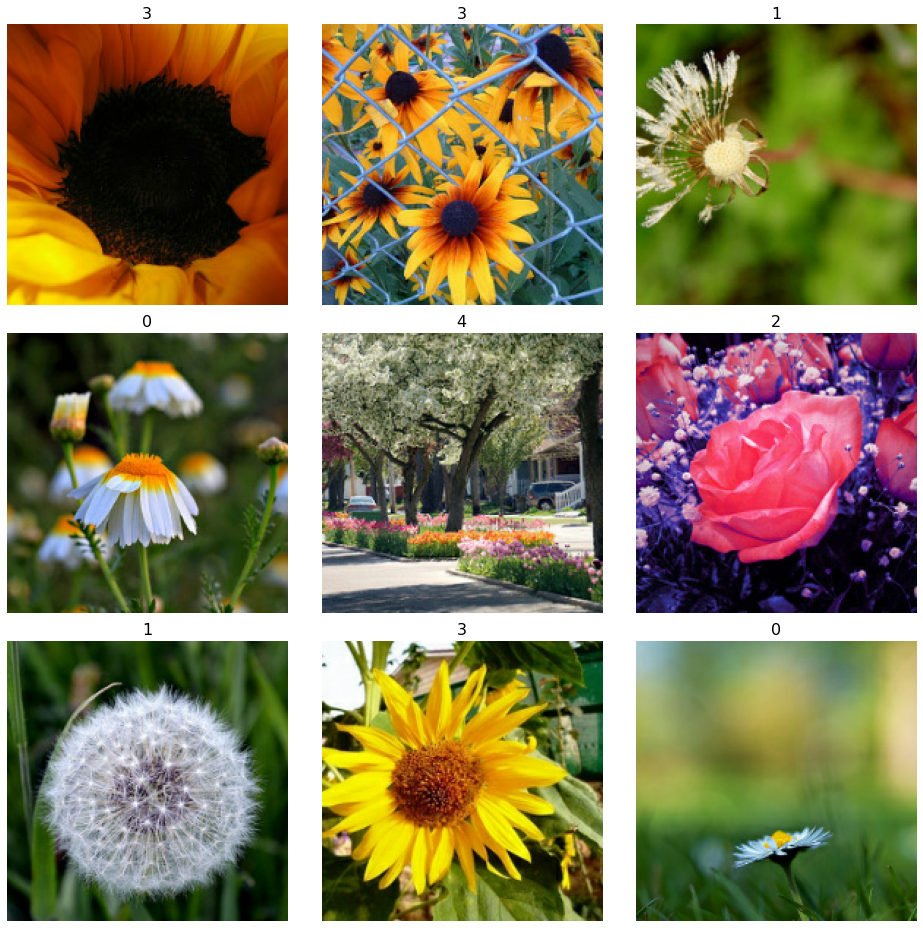

In [97]:


### CODING TASK ###

#Reading from  the new TF record files to display 9 images 

TFRecRDD = load_dataset(filenames_convert_to_rdd_collect)
display_9_images_from_dataset(TFRecRDD)





ii) Write your code it into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run it locally in Spark. 



In [98]:
### CODING TASK ###

###Creating a magic function so that we can create the entire file into a python script file


%%writefile spark_write_tfrec.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
AUTO = tf.data.experimental.AUTOTUNE 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.2.1-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/root/spark-2.4.8-bin-hadoop2.7"



import pyspark
print(pyspark.__version__)
print(scipy.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

#Function1 
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

#Function2
def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

#Function3
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2


#Function4
def resize_and_crop_image(RDD):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    image, label = RDD
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

#Function5
def recompress_image(RDD):
    # this reduces the amount of data, but takes some time
    image, label = RDD
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

#Function6
def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

#Function7
def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  


#Function8
def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]) #,        # one class in the list
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

#Function9
def write_tfrecord(index,partition):
  filename = GCS_OUTPUT + "{}.tfrec".format(index)
  with tf.io.TFRecordWriter(filename) as out_file:
    for element in partition:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), # re-compressed image: already a byte string
                            label.numpy() #, height.numpy()[i], width.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
  yield (filename)

#FUnction10
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


#Function11
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files

PROJECT = 'bdvk210033252'  ### USE YOUR PROJECT ID HERE. ### 
BUCKET = 'gs://{}-storage'.format(PROJECT)
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)

### CODING TASK ###

### CODING TASK ###

### Part 1 ###



filenames = tf.io.gfile.glob(GCS_PATTERN)



#sc = pyspark.SparkContext()
  
### Part 2 ###
imageRDD = sc.parallelize(filenames)

### Part 3 ###
sampledRDD = imageRDD.sample(False, 0.02)
  
  
### Part 4 ###
  
decodedRDD = sampledRDD.map(decode_jpeg_and_label)
  
resizedRDD = decodedRDD.map(resize_and_crop_image)  
  
recompressedRDD = resizedRDD.map(recompress_image)  

### Part 5 ###
  
filenames_convert_to_rdd_collect = recompressedRDD.mapPartitionsWithIndex(write_tfrecord).collect()

TFRecRDD = load_dataset(filenames_convert_to_rdd_collect)
display_9_images_from_dataset(TFRecRDD)

#%run spark_write_tfrec.py


Overwriting spark_write_tfrec.py


In [99]:
### Running it locally on spark 

Tensorflow version 2.8.0
2.4.8
1.4.1
<SparkContext master=local[*] appName=pyspark-shell>


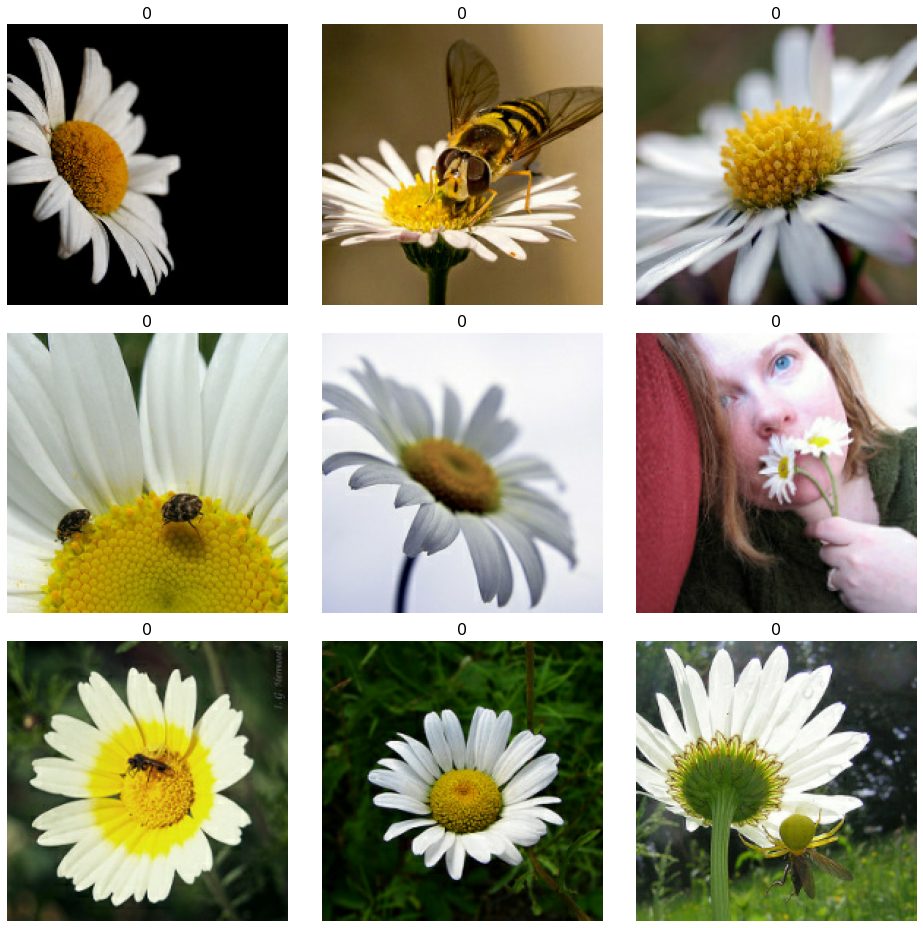

<Figure size 432x288 with 0 Axes>

In [100]:
%run spark_write_tfrec.py

### 1c) Set up a cluster and run the script. (4%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs. 

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install). 
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`. 

When the cluster is running, run your script to check that it works and keep the output cell output. (2%)


In [55]:
### Setting up a cluster for a single machine using the cluster deifning fuctions

In [117]:
!gcloud dataproc clusters create $CLUSTER \
  --image-version 1.5-ubuntu18 \
  --single-node \
  --master-machine-type n1-standard-8 \
  --master-boot-disk-type pd-ssd \
  --master-boot-disk-size 100 \
  --max-idle 3600s \
  --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata "PIP_PACKAGES=tensorflow==2.4.0 scipy==1.4.1 pandas numpy==1.21.6 matplotlib"


Waiting on operation [projects/bdvk210033252/regions/us-central1/operations/278547dc-5899-346a-aba7-57d2a186d95a].
Created [https://dataproc.googleapis.com/v1/projects/bdvk210033252/regions/us-central1/clusters/bdvk210033252-cluster] Cluster placed in zone [us-central1-b].


In [118]:
### Running the saved python script on the google cloud single cluster named -bdvk210033252-cluster 

In [119]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_write_tfrec.py

Job [d617d96f864d47debdb07a9da488a3b6] submitted.
Waiting for job output...
2022-05-04 02:10:33.334022: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 02:10:33.334066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
1.4.1
22/05/04 02:10:36 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 02:10:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 02:10:36 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 02:10:36 INFO org.spark_project.jetty.util.log: Logging initialized @8953ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 02:10:36 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNA

In [225]:
### CODING TASK ###

###Creating a magic function so that we can create the entire file into a python script file


%%writefile spark_write_tfrec.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
AUTO = tf.data.experimental.AUTOTUNE 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.2.1-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/root/spark-2.4.8-bin-hadoop2.7"



import pyspark
print(pyspark.__version__)
print(scipy.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

#Function1 
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

#Function2
def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

#Function3
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2


#Function4
def resize_and_crop_image(RDD):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    image, label = RDD
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

#Function5
def recompress_image(RDD):
    # this reduces the amount of data, but takes some time
    image, label = RDD
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

#Function6
def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

#Function7
def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  


#Function8
def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]) #,        # one class in the list
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

#Function9
def write_tfrecord(index,partition):
  filename = GCS_OUTPUT + "{}.tfrec".format(index)
  with tf.io.TFRecordWriter(filename) as out_file:
    for element in partition:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), # re-compressed image: already a byte string
                            label.numpy() #, height.numpy()[i], width.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
  yield (filename)

#FUnction10
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


#Function11
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files

PROJECT = 'bdvk210033252'  ### USE YOUR PROJECT ID HERE. ### 
BUCKET = 'gs://{}-storage'.format(PROJECT)
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)

### CODING TASK ###

### CODING TASK ###

### Part 1 ###



filenames = tf.io.gfile.glob(GCS_PATTERN)



#sc = pyspark.SparkContext()
  
### Part 2 ###
imageRDD = sc.parallelize(filenames)

### Part 3 ###
sampledRDD = imageRDD.sample(False, 0.02)
  
  
### Part 4 ###
  
decodedRDD = sampledRDD.map(decode_jpeg_and_label)
  
resizedRDD = decodedRDD.map(resize_and_crop_image)  
  
recompressedRDD = resizedRDD.map(recompress_image)  

### Part 5 ###
  
filenames_convert_to_rdd_collect = recompressedRDD.mapPartitionsWithIndex(write_tfrecord).collect()

TFRecRDD = load_dataset(filenames_convert_to_rdd_collect)
display_9_images_from_dataset(TFRecRDD)

#%run spark_write_tfrec.py


Overwriting spark_write_tfrec.py


Run the script in the cloud and test the output. 

In [120]:
## The Script is thus running successfuly on the cluster created.

In the free credit tier on Google Cloud, there are the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk* 
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details 
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**. 
Each of them with 1 (virtual) CPU. 
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput. 

Once the cluster is running, test your script. (2%)

In [121]:
#Creating a maximal cluster using the said fucntions and workers nodes

In [122]:
### CODING TASK ###

!gcloud dataproc clusters create bdcwvk-maxcluster \
  --image-version 1.5-ubuntu18 \
  --num-workers 7 \
  --master-machine-type n1-standard-1 \
  --master-boot-disk-type pd-ssd \
  --master-boot-disk-size 100 \
  --worker-boot-disk-type pd-ssd \
  --worker-boot-disk-size 100 \
  --max-idle 3600s \
  --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata "PIP_PACKAGES=tensorflow==2.4.0 scipy==1.4.1 pandas numpy==1.21.6 matplotlib"


ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Multiple validation errors:
 - Insufficient 'CPUS' quota. Requested 29.0, available 16.0.
 - Insufficient 'CPUS_ALL_REGIONS' quota. Requested 29.0, available 24.0.
 - Insufficient 'IN_USE_ADDRESSES' quota. Requested 8.0, available 7.0.
 - Insufficient 'SSD_TOTAL_GB' quota. Requested 800.0, available 400.0.


In [123]:
### 7 worker nodes cannot be created because of the insufficent storage we attempt to do with lesser number of workers

In [124]:
### CODING TASK ###

# Considering workers as 4

!gcloud dataproc clusters create bdcwvk-maxcluster \
  --image-version 1.5-ubuntu18 \
  --num-workers 4 \
  --master-machine-type n1-standard-1 \
  --master-boot-disk-type pd-ssd \
  --master-boot-disk-size 100 \
  --worker-boot-disk-type pd-ssd \
  --worker-boot-disk-size 100 \
  --max-idle 3600s \
  --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata "PIP_PACKAGES=tensorflow==2.4.0 scipy==1.4.1 pandas numpy==1.21.6 matplotlib"


ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Multiple validation errors:
 - Insufficient 'CPUS' quota. Requested 17.0, available 16.0.
 - Insufficient 'SSD_TOTAL_GB' quota. Requested 500.0, available 400.0.


In [125]:
# Considering workers as 3

!gcloud dataproc clusters create bdcwvk-maxcluster \
  --image-version 1.5-ubuntu18 \
  --num-workers 3 \
  --master-machine-type n1-standard-1 \
  --master-boot-disk-type pd-ssd \
  --master-boot-disk-size 100 \
  --worker-boot-disk-type pd-ssd \
  --worker-boot-disk-size 100 \
  --max-idle 3600s \
  --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata "PIP_PACKAGES=tensorflow==2.4.0 scipy==1.4.1 pandas numpy==1.21.6 matplotlib"

Waiting on operation [projects/bdvk210033252/regions/us-central1/operations/a2143b9c-7cf0-3548-b227-a95722deba35].

Created [https://dataproc.googleapis.com/v1/projects/bdvk210033252/regions/us-central1/clusters/bdcwvk-maxcluster] Cluster placed in zone [us-central1-b].


In [126]:
# Thus a maximal cluster is created named - bdcwvk-maxcluster

# We run the same python script in the max cluster 

In [127]:
!gcloud dataproc jobs submit pyspark --cluster bdcwvk-maxcluster --region $REGION \
    ./spark_write_tfrec.py

Job [7d974ba54a3c45e89c1543be2baaafca] submitted.
Waiting for job output...
2022-05-04 02:17:23.096208: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 02:17:23.096381: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
1.4.1
22/05/04 02:17:27 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 02:17:27 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 02:17:28 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 02:17:28 INFO org.spark_project.jetty.util.log: Logging initialized @14403ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 02:17:28 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SN

In [112]:
## Thus a maximal cluster is created and the python script is running in the same.

### 1d)	Optimisation, experiments, and discussion (14%)

i) Improve parallelisation 

If you implemented a straightfoward version, you will 
**probably** observe that **all the computation** is done on only **two nodes**. 
This can be adressed by using the **second parameter** in the initial call to **parallelize**. 
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`. 

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (5%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources. 
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (6%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (3%)

Write the code below and your answers in the report.


In [ ]:
# Making the parellisation function to add the second parameter of repition in to the script.

In [227]:
### CODING TASK ###

###Creating a magic function so that we can create the entire file into a python script file


%%writefile spark_write_tfrec.py

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
AUTO = tf.data.experimental.AUTOTUNE 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.2.1-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/root/spark-2.4.8-bin-hadoop2.7"



import pyspark
print(pyspark.__version__)
print(scipy.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

#Function1 
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

#Function2
def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

#Function3
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2


#Function4
def resize_and_crop_image(RDD):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    image, label = RDD
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

#Function5
def recompress_image(RDD):
    # this reduces the amount of data, but takes some time
    image, label = RDD
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

#Function6
def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

#Function7
def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  


#Function8
def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]) #,        # one class in the list
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

#Function9
def write_tfrecord(index,partition):
  filename = GCS_OUTPUT + "{}.tfrec".format(index)
  with tf.io.TFRecordWriter(filename) as out_file:
    for element in partition:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), # re-compressed image: already a byte string
                            label.numpy() #, height.numpy()[i], width.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
  yield (filename)

#FUnction10
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


#Function11
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files

PROJECT = 'bdvk210033252'  ### USE YOUR PROJECT ID HERE. ### 
BUCKET = 'gs://{}-storage'.format(PROJECT)
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)

### CODING TASK ###

### CODING TASK ###

### Part 1 ###



filenames = tf.io.gfile.glob(GCS_PATTERN)



#sc = pyspark.SparkContext()

### TASK 1D###
  
### Part 2 ###
imageRDD = sc.parallelize(filenames,3)

### Part 3 ###
sampledRDD = imageRDD.sample(False, 0.02)
  
  
### Part 4 ###
  
decodedRDD = sampledRDD.map(decode_jpeg_and_label)
  
resizedRDD = decodedRDD.map(resize_and_crop_image)  
  
recompressedRDD = resizedRDD.map(recompress_image)  

### task 1 D### 
data_repartition_rdd = recompressedRDD.repartition(3)

### Part 5 ###



### Part 5 ###
  
##filenames_convert_to_rdd_collect = recompressedRDD.mapPartitionsWithIndex(write_tfrecord).collect()

  
filenames_convert_to_rdd_collect = data_repartition_rdd.mapPartitionsWithIndex(write_tfrecord).collect()

TFRecRDD = load_dataset(filenames_convert_to_rdd_collect)
display_9_images_from_dataset(TFRecRDD)

#%run spark_write_tfrec.py


Overwriting spark_write_tfrec.py


In [222]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_write_tfrec.py

Job [adef42b3b05249b6a5ebef5f9ce17c85] submitted.
Waiting for job output...
2022-05-04 10:06:48.401837: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 10:06:48.401882: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
1.4.1
22/05/04 10:06:50 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 10:06:50 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 10:06:50 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 10:06:50 INFO org.spark_project.jetty.util.log: Logging initialized @5356ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 10:06:50 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNA

In [228]:
!gcloud dataproc jobs submit pyspark --cluster bdcw210033252-maxcluster --region $REGION \
    ./spark_write_tfrec.py

Job [b31ce63bac704ca7b8c1dcdc7a3171fd] submitted.
Waiting for job output...
2022-05-04 10:26:52.496861: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 10:26:52.497031: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
1.4.1
22/05/04 10:26:56 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 10:26:56 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 10:26:56 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 10:26:56 INFO org.spark_project.jetty.util.log: Logging initialized @9125ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 10:26:57 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNA

In [229]:
### Part 2



In [236]:
#1 machine with 8-fold resources (8 vCPUs) to check the working 

!gcloud dataproc clusters create $CLUSTER \
  --image-version 1.5-ubuntu18 \
  --master-machine-type n1-standard-4 \
  --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
  --num-workers 0 \
  --max-idle 3600s \
  --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata "PIP_PACKAGES=tensorflow==2.4.0 scipy==1.4.1 pandas numpy==1.21.6 matplotlib"





Waiting on operation [projects/bdvk210033252/regions/us-central1/operations/064f1840-39a9-372d-b6af-734b4b91941c].
Created [https://dataproc.googleapis.com/v1/projects/bdvk210033252/regions/us-central1/clusters/bdvk210033252-cluster] Cluster placed in zone [us-central1-b].


In [237]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_write_tfrec.py

Job [ed69c4db705f434b842e1c5f07035423] submitted.
Waiting for job output...
2022-05-04 11:07:09.321664: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 11:07:09.321704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
1.4.1
22/05/04 11:07:12 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 11:07:12 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 11:07:12 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 11:07:12 INFO org.spark_project.jetty.util.log: Logging initialized @9252ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 11:07:12 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNA

In [238]:
### CODING TASK ### 
#(2 vCPUs, memory, disk)

#Master with 2vCPU +4 Workers with 2vCPU

!gcloud dataproc clusters create $CLUSTER \
  --image-version 1.5-ubuntu18 \
  --master-machine-type n1-standard-2 \
  --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
  --num-workers 2 --worker-machine-type n1-standard-2 --worker-boot-disk-size 100 \
  --max-idle 3600s \
  --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata "PIP_PACKAGES=tensorflow==2.4.0 scipy==1.4.1 pandas numpy==1.21.6 matplotlib"








Waiting on operation [projects/bdvk210033252/regions/us-central1/operations/f4601a53-04eb-3e32-a5c3-eac4cff9b169].

Created [https://dataproc.googleapis.com/v1/projects/bdvk210033252/regions/us-central1/clusters/bdvk210033252-cluster] Cluster placed in zone [us-central1-b].


In [239]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_write_tfrec.py

Job [b6ec211cc54d47899e1999f0cd8844d3] submitted.
Waiting for job output...
2022-05-04 11:16:26.264603: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 11:16:26.264645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2.4.8
1.4.1
22/05/04 11:16:29 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 11:16:29 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 11:16:29 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 11:16:29 INFO org.spark_project.jetty.util.log: Logging initialized @9970ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 11:16:29 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNA

# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly. 
This task is about **measuring this effect** and **parallelizing the tests with PySpark**. 

## 2.1 Speed test implementation 

Here is **code for time measurement** to determine the **throughput in images per second**. 
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read. 
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`. 
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`). 
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings. 

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**. 
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions. 

In [22]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
# batch_sizes = [2,4] 
# batch_numbers = [3,6] 
# repetitions = [1]


batch_sizes = [2,4,6,8] 
batch_numbers = [3,6,9,12] 
repetitions = [1,2,3] 


def time_configs(dataset, batch_sizes, batch_numbers, repetitions): 
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)] 
    print(dims) 
    results = np.zeros(dims) 
    params = np.zeros(dims + [3]) 
    print( results.shape ) 
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking 
        for bsi,bs in enumerate(batch_sizes): 
            for dsi, ds in enumerate(batch_numbers): 
                batched_dataset = dataset.batch(bs)  
                timing_set = batched_dataset.take(ds) 
                for ri,rep in enumerate(repetitions): 
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep)) 
                    t0 = time.time() 
                    for image, label in timing_set: 
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape, 
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td 
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params





**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset2) and the TFRecord files (datasetDecoded). 

In [23]:
### CODING TASK

### Reading the files from the data set

### Image files are dsetRezied and TF record files are dataasetTFre in our case 

[res,par] = time_configs(dsetResized,batch_sizes, batch_numbers, repetitions)
print(res) 
print(par) 

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)






[4, 4, 3]
(4, 4, 3)
bs: 2, ds: 3, rep: 1
Image batch shape (2, 192, 192, 3), ["b'daisy'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2, 192, 192, 3), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2, 192, 192, 3), ["b'dandelion'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 3, rep: 2
Image batch shape (2, 192, 192, 3), ["b'tulips'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2, 192, 192, 3), ["b'sunflowers'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2, 192, 192, 3), ["b'sunflowers'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 3, rep: 3
Image batch shape (2, 192, 192, 3), ["b'sunflowers'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Im

In [24]:
def time_configs(dataset,batch_size,batch_number,repetition):
  start=time.time()
  dataset1=dataset.batch(batch_size)
  test_set=dataset1.take(batch_number)
  for i in range(repetition):
    for image in test_set:
      print('string', file=open("/dev/null",mode='w')); #This is the null device
  end=time.time();
  total_images=batch_size*batch_number*repetition
  throughput=total_images/(end-start); #determine the throughput in images per second
  return throughput 


In [25]:
import pandas as pd
### CODING TASK ###
columns=["datatype","batch_size","batch_number","repetition","dataset_size","reading_speed"]
df_speedtests=pd.DataFrame(columns=columns) #we initiate our dataframe
for batch_size in batch_sizes:
  for batch_number in batch_numbers:
    for repetition in repetitions:
      dataset_size=batch_size*batch_number
    #  #speed images
      read_speed=time_configs(dsetResized,batch_size,batch_number,repetition)
      df_speedtests=df_speedtests.append({'datatype':"dsetResized",'batch_size':batch_size,'batch_number':batch_number,'repetition': repetition,'dataset_size':dataset_size,'reading_speed':read_speed},ignore_index=True)
      #speed TF record 
      read_speed27=time_configs(datasetTfrec,batch_size,batch_number,repetition)
      df_speedtests=df_speedtests.append({'datatype': "datasetTfrec", 'batch_size':batch_size, 'batch_number':batch_number,'repetition':repetition,'dataset_size':dataset_size,'reading_speed': read_speed27}, ignore_index=True)




In [26]:
dsetResized

<MapDataset element_spec=(TensorSpec(shape=(192, 192, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [27]:
datasetTfrec

<MapDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [28]:
df_speedtests

datatype batch_size batch_number repetition dataset_size  \
0    dsetResized          2            3          1            6   
1   datasetTfrec          2            3          1            6   
2    dsetResized          2            3          2            6   
3   datasetTfrec          2            3          2            6   
4    dsetResized          2            3          3            6   
..           ...        ...          ...        ...          ...   
91  datasetTfrec          8           12          1           96   
92   dsetResized          8           12          2           96   
93  datasetTfrec          8           12          2           96   
94   dsetResized          8           12          3           96   
95  datasetTfrec          8           12          3           96   

    reading_speed  
0       28.299387  
1       86.503979  
2       29.154308  
3       80.808099  
4       24.857631  
..            ...  
91     557.443552  
92      72.638264  
93     385.222815  
94      63.567146  
95     590.354397  

[96 rows x 6 columns]

In [29]:
#We understand that the speedtest for the TF record file is on a higher scale than the normal image records.

## Task 2: Parallelising the speed test with Spark in the cloud. (30%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark. 
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later). 


### 2a) Create the script (12%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc. 
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**. 
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically: 
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (1%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%) 
*   vi) write the results to a pickle file in your bucket (1%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [30]:
### CODING TASK ###

#Load modules and pre existing fucntion to work with as per the existing.

import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row



def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  
        "class": tf.io.FixedLenFeature([], tf.int64) 
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
  
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

def resize_and_crop_image(image, label):
   
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def time_configs_rdd(spark_df_parameters_rdd_row):
  start=time.time();

  if (spark_df_parameters_rdd_row['datatype']=='datasetDecoded'):
    dataset = load_dataset(filenames)
    print('dvbbv')
  else:
    filenames_fn = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset_fn = filenames_fn.map(decode_jpeg_and_label)
    dataset = dataset_fn.map(resize_and_crop_image)  
    print('12224')
 
  dataset1 = dataset.batch(spark_df_parameters_rdd_row['batch_size'])
  test_set = dataset1.take(spark_df_parameters_rdd_row['batch_number'])
  for i in range(spark_df_parameters_rdd_row['repetition']):
    for image in test_set:
      print('string', file=open("/dev/null", mode='w'));
  end=time.time();
  total_images=spark_df_parameters_rdd_row['batch_size']*spark_df_parameters_rdd_row['batch_number']*spark_df_parameters_rdd_row['repetition']
  total_time=total_images/(end-start);
  return total_time


def time_configs(dataset,batch_size,batch_number,repetition):
  start=time.time()
  dataset1=dataset.batch(batch_size)
  test_set=dataset1.take(batch_number)
  for i in range(repetition):
    for image in test_set:
      print('string', file=open("/dev/null",mode='w')); #This is the null device
  end=time.time();
  total_images=batch_size*batch_number*repetition
  throughput=total_images/(end-start); #determine the throughput in images per second
  return throughput 






In [31]:
#We create the datatypes for the said rule as per the testing values.The we attempt the change the same using other combinations 

In [32]:
#create datatypes from the a
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DecimalType

appName = "PySpark DataFrame"
master = 'local'

# Create Spark session
spark = SparkSession.builder \
    .master(master) \
    .appName(appName) \
    .getOrCreate()

data = [("dsetResized",2,3,1,6),("datasetTfrec",2,3,1,6),("dsetResized",2,6,1,12),("datasetTfrec",2,6,1,12),("dsetResized",3,4,1,12),("datasetTfrec",3,4,1,12),("dsetResized",3,6,1,24),("datasetTfrec",3,6,1,24)]   

#Create a Schema for dataframe
schema = StructType([
                     StructField("Datatype",StringType(),True),
                     StructField("batch_size", IntegerType(), True),
                     StructField("batch_number", IntegerType(),True),
                     StructField("repetition", IntegerType(),True),
                     StructField("dataset_size", IntegerType(),True),
                     ])
# Convert list to RDD
rdd = spark.sparkContext.parallelize(data)

# Convert list to data frame
df_Speedtests = spark.createDataFrame(rdd, schema)
print(df_Speedtests.schema)
df_Speedtests.show()

StructType(List(StructField(Datatype,StringType,true),StructField(batch_size,IntegerType,true),StructField(batch_number,IntegerType,true),StructField(repetition,IntegerType,true),StructField(dataset_size,IntegerType,true)))
+------------+----------+------------+----------+------------+
|    Datatype|batch_size|batch_number|repetition|dataset_size|
+------------+----------+------------+----------+------------+
| dsetResized|         2|           3|         1|           6|
|datasetTfrec|         2|           3|         1|           6|
| dsetResized|         2|           6|         1|          12|
|datasetTfrec|         2|           6|         1|          12|
| dsetResized|         3|           4|         1|          12|
|datasetTfrec|         3|           4|         1|          12|
| dsetResized|         3|           6|         1|          24|
|datasetTfrec|         3|           6|         1|          24|
+------------+----------+------------+----------+------------+



In [33]:
#Lets test the perfomrnce by increasing the dataset batches

In [34]:
#create datatypes
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DecimalType

appName = "PySpark DataFrame"
master = 'local'

# Create Spark session
spark = SparkSession.builder \
    .master(master) \
    .appName(appName) \
    .getOrCreate()

data = [("dsetResized",2,3,1,6),("datasetTfrec",2,3,1,6),("dsetResized",2,3,2,6),("datasetTfrec",2,3,2,6),("dsetResized",2,3,3,6),("datasetTfrec",2,3,2,6),("dsetResized",2,6,1,12),("datasetTfrec",2,6,1,12),("dsetResized",2,6,2,12),("datasetTfrec",2,6,2,12),
              ("dsetResized",2,6,3,12),("datasetTfrec",2,6,3,12),("dsetResized",2,9,1,18),("datasetTfrec",2,9,1,18),("dsetResized",2,9,2,18),("datasetTfrec",2,9,2,18),("dsetResized",2,9,3,18),("datasetTfrec",2,9,3,18),("dsetResized",2,12,1,24),
              ("datasetTfrec",2,12,1,24),("dsetResized",2,12,2,24),("datasetTfrec",2,12,2,24),("dsetResized",2,12,3,24),("datasetTfrec",2,12,3,24),("dsetResized",4,3,1,12),("datasetTfrec",4,3,1,12),("dsetResized",4,3,2,12 ),  ("datasetTfrec",4,3,2,12),
              ("dsetResized",4,3,3,12),("datasetTfrec",4,3,3,12),("dsetResized",4,6,1,24),("datasetTfrec",4,6,1,24),("dsetResized",4,6,2,24),("datasetTfrec",4,6,2,24),("dsetResized",4,6,3,24),("datasetTfrec",4,6,3,24),("dsetResized",4,9,1,36),
              ("datasetTfrec",4,9,1,36),("dsetResized",4,9,2,36),("datasetTfrec",4,9,2,36),("dsetResized",4,9,3,36),("datasetTfrec",4,9,3,36),("dsetResized",4,12,1,48),("datasetTfrec",4,12,1,48),("dsetResized",4,12,2,48),("datasetTfrec",4,12,2,48),
              ("dsetResized",4,12,3,48),("datasetTfrec",4,12,3,48),("dsetResized",6,3,1,18),("datasetTfrec",6,3,1,18),("dsetResized",6,3,2,18),("datasetTfrec",6,3,2,18),("dsetResized",6,3,3,18),("datasetTfrec",6,3,3,18),("dsetResized",6,6,1,36),
              ("datasetTfrec",6,6,1,36),("dsetResized",6,6,2,36),("datasetTfrec",6,6,2,36),("dsetResized",6,6,3,36),("datasetTfrec",6,6,3,36),("dsetResized",6,9,1,54),("datasetTfrec",6,9,1,54),("dsetResized",6,9,2,54),("datasetTfrec",6,9,2,54),
              ("dsetResized",6,9,3,54),("datasetTfrec",6,9,3,54),("dsetResized",6,12,1,72),("datasetTfrec",6,12,1,72),("dsetResized",6,12,2,72),("datasetTfrec",6,12,2,72),("dsetResized",6,12,3,72),("datasetTfrec",6,12,3,72),("dsetResized",8,3,1,24),
              ("datasetTfrec",8,3,1,24),("dsetResized",8,3,2,24),("datasetTfrec",8,3,2,24), ("dsetResized",8,3,3,24), ("datasetTfrec",8,3,3,24), ("dsetResized",8,6,1,48),("datasetTfrec",8,6,1,48),("dsetResized",8,6,2,48),  ("datasetTfrec",8,6,2,48),
              ("dsetResized",8,6,3,48),("datasetTfrec",8,6,3,48), ("dsetResized",8,9,1,72), ("datasetTfrec",8,9,1,72), ("dsetResized",8,9,2,72), ("datasetTfrec",8,9,2,72), ("dsetResized",8,9,3,72), ("datasetTfrec",8,9,3,72), ("dsetResized",8,12,1,96),
              ("datasetTfrec",8,12,1,96),("dsetResized",8,12,2,96),("datasetTfrec",8,12,2,96),("dsetResized",8,12,3,96),("datasetTfrec",8,12,3,96)]   

#Create a Schema for dataframe
schema = StructType([
                     StructField("Datatype",StringType(),True),
                     StructField("batch_size", IntegerType(), True),
                     StructField("batch_number", IntegerType(),True),
                     StructField("repetition", IntegerType(),True),
                     StructField("dataset_size", IntegerType(),True)
                     ])
# Convert list to RDD
rdd = spark.sparkContext.parallelize(data)

# Convert list to data frame
df_Speedtests = spark.createDataFrame(rdd, schema)
print(df_Speedtests.schema)
df_Speedtests.show()

StructType(List(StructField(Datatype,StringType,true),StructField(batch_size,IntegerType,true),StructField(batch_number,IntegerType,true),StructField(repetition,IntegerType,true),StructField(dataset_size,IntegerType,true)))
+------------+----------+------------+----------+------------+
|    Datatype|batch_size|batch_number|repetition|dataset_size|
+------------+----------+------------+----------+------------+
| dsetResized|         2|           3|         1|           6|
|datasetTfrec|         2|           3|         1|           6|
| dsetResized|         2|           3|         2|           6|
|datasetTfrec|         2|           3|         2|           6|
| dsetResized|         2|           3|         3|           6|
|datasetTfrec|         2|           3|         2|           6|
| dsetResized|         2|           6|         1|          12|
|datasetTfrec|         2|           6|         1|          12|
| dsetResized|         2|           6|         2|          12|
|datasetTfrec|      

In [35]:
#We are creating a row list which houses all necessary sets of data in the cell corresponsind

In [36]:
##part 1) A combination of all cells in the previous iterantions to create a dataset and 
#thereby to have the code to create a dataset based on a list of paranmeter combinations in EDD



In [37]:
df_speedtests1=df_speedtests.iloc[:,:-1]

In [38]:
row_list = df_Speedtests.select("datatype","batch_size","batch_number","repetition","dataset_size").collect()

In [39]:
 ## part 2 Getting a Spark context and creating the run timning pararlley to test the timing in each comibation in parallel

In [40]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df_param=sqlContext.createDataFrame(df_speedtests1)
spark_df_param_rdd=df_param.rdd
df_params_rdd = spark_df_param_rdd.map(lambda row: Row(type=str(row["datatype"]),batch_size = int(row["batch_size"]),batch_number=int(row["batch_number"]),repetition=int(row["repetition"]),dataset_size=int(row["dataset_size"]),imagesPerSec=float(time_configs_rdd(row))))
df_params_rdd.take(16)

[Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=3.759885006416172, repetition=1, type='dsetResized'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=8.534114654865457, repetition=1, type='datasetTfrec'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=13.774144809057962, repetition=2, type='dsetResized'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=13.76513397251275, repetition=2, type='datasetTfrec'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=15.614727311196631, repetition=3, type='dsetResized'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=17.04354217751974, repetition=3, type='datasetTfrec'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=15.751790209173045, repetition=1, type='dsetResized'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=17.367502681126116, repetition=1, type='datasetTfrec'),
 Row(batch_number=6, batch_size=2, dataset_siz

In [41]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark_df_param = sqlContext.createDataFrame(row_list)
spark_df_parameters_rdd_row=spark_df_param.rdd
df_params_rdd1 = spark_df_parameters_rdd_row.map(lambda row: Row(type=str(row["datatype"]),batch_size = int(row["batch_size"]),batch_number=int (row["batch_number"]),repetition=int(row["repetition"]),dataset_size=int(row["dataset_size"]),imagesPerSec=float(time_configs_rdd(row))))
df_params_rdd1.take(16)


[Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=3.976869332080077, repetition=1, type='dsetResized'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=9.74503199704464, repetition=1, type='datasetTfrec'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=14.218437542903924, repetition=2, type='dsetResized'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=13.127482644408666, repetition=2, type='datasetTfrec'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=16.43170471912597, repetition=3, type='dsetResized'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=14.299360797169655, repetition=2, type='datasetTfrec'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=16.822243538538153, repetition=1, type='dsetResized'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=17.326345648072923, repetition=1, type='datasetTfrec'),
 Row(batch_number=6, batch_size=2, dataset_siz

In [42]:
#iii) Converting the RDD into the array and save the values in the same set.

RDD_array=df_params_rdd.map(np.array)
RDD_array.take(16)

[array(['3', '2', '6', '3.753607909748113', '1', 'dsetResized'],
       dtype='<U32'),
 array(['3', '2', '6', '9.221766981475353', '1', 'datasetTfrec'],
       dtype='<U32'),
 array(['3', '2', '6', '14.47534641334921', '2', 'dsetResized'],
       dtype='<U32'),
 array(['3', '2', '6', '12.957306904347673', '2', 'datasetTfrec'],
       dtype='<U32'),
 array(['3', '2', '6', '16.251319683633255', '3', 'dsetResized'],
       dtype='<U32'),
 array(['3', '2', '6', '17.185079027833705', '3', 'datasetTfrec'],
       dtype='<U32'),
 array(['6', '2', '12', '16.93538686822022', '1', 'dsetResized'],
       dtype='<U32'),
 array(['6', '2', '12', '16.077696847111316', '1', 'datasetTfrec'],
       dtype='<U32'),
 array(['6', '2', '12', '24.516301369662838', '2', 'dsetResized'],
       dtype='<U32'),
 array(['6', '2', '12', '24.48489300432643', '2', 'datasetTfrec'],
       dtype='<U32'),
 array(['6', '2', '12', '26.41457293552704', '3', 'dsetResized'],
       dtype='<U32'),
 array(['6', '2', '12', '29.

In [43]:
#creating RDD with all results for each parameter as (parameter_value,images_per_second) and collecting  the result for each parameter
#Entire parametric ombinations 

In [44]:
#Entire parametric ombinations 
dsetResized_readspeed_rdd=df_params_rdd.filter(lambda row: row['type']=='dsetResized')
datasetTfrec_readspeed_rdd=df_params_rdd.filter(lambda row: row['type']=='datasetTfrec')

In [45]:
#dsetResized
dsetResized_readspeed_rdd.take(16)

[Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=4.113858188761794, repetition=1, type='dsetResized'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=12.977479280030034, repetition=2, type='dsetResized'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=15.916266252000668, repetition=3, type='dsetResized'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=16.868932385379306, repetition=1, type='dsetResized'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=24.066853262749742, repetition=2, type='dsetResized'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=27.71110263233091, repetition=3, type='dsetResized'),
 Row(batch_number=9, batch_size=2, dataset_size=18, imagesPerSec=22.617028166782053, repetition=1, type='dsetResized'),
 Row(batch_number=9, batch_size=2, dataset_size=18, imagesPerSec=31.358487697715656, repetition=2, type='dsetResized'),
 Row(batch_number=9, batch_size=2, dataset_si

In [46]:
#datasetTfrec
datasetTfrec_readspeed_rdd.take(16)

[Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=8.797907169998389, repetition=1, type='datasetTfrec'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=12.694256497301959, repetition=2, type='datasetTfrec'),
 Row(batch_number=3, batch_size=2, dataset_size=6, imagesPerSec=16.94527167322317, repetition=3, type='datasetTfrec'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=14.624439942678023, repetition=1, type='datasetTfrec'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=23.249662387430718, repetition=2, type='datasetTfrec'),
 Row(batch_number=6, batch_size=2, dataset_size=12, imagesPerSec=23.825816404734333, repetition=3, type='datasetTfrec'),
 Row(batch_number=9, batch_size=2, dataset_size=18, imagesPerSec=21.621634501379823, repetition=1, type='datasetTfrec'),
 Row(batch_number=9, batch_size=2, dataset_size=18, imagesPerSec=29.67183890992625, repetition=2, type='datasetTfrec'),
 Row(batch_number=9, batch_size=2, dat

In [47]:
#Each cominationed mapped after combining in images files
dsetResized_batchnum_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(batch_number=int(row["batch_number"]),imagesPerSec=float(row["imagesPerSec"])))
dsetResized_repetition_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(repetition=int(row["repetition"]),imagesPerSec=float(row["imagesPerSec"])))
dsetResized_batchsize_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(batch_size=int(row["batch_size"]),imagesPerSec=float(row["imagesPerSec"])))
dsetResized_datasize_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(dataset_size=int(row["dataset_size"]),imagesPerSec=float(row["imagesPerSec"])))


#Each cominationed mapped after combining in images files in TF record files
datasetTfrec_datasize_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(dataset_size=int(row["dataset_size"]),imagesPerSec=float(row["imagesPerSec"])))
datasetTfrec_batchsize_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(batch_size=int(row["batch_size"]),imagesPerSec=float(row["imagesPerSec"])))
datasetTfrec_repetition_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(repetition=int(row["repetition"]),imagesPerSec=float(row["imagesPerSec"])))
datasetTfrec_batchnum_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(batch_number=int(row["batch_number"]),imagesPerSec=float(row["imagesPerSec"])))



# Actionning the collection after suitable extraction 


dsetResized_batchnum_speed=dsetResized_batchnum_speed_rdd.collect()
dsetResized_repetition_speed=dsetResized_repetition_speed_rdd.collect()
dsetResized_batchsize_speed=dsetResized_batchsize_speed_rdd.collect()
dsetResized_datasize_speed=dsetResized_datasize_speed_rdd.collect()

datasetTfrec_datasize_speed=datasetTfrec_datasize_speed_rdd.collect()
datasetTfrec_batchsize_speed=datasetTfrec_batchsize_speed_rdd.collect()
datasetTfrec_repetition_speed=datasetTfrec_repetition_speed_rdd.collect()
datasetTfrec_batchnum_speed=datasetTfrec_batchnum_speed_rdd.collect()


In [48]:
dsetResized_batchsize_speed

[Row(batch_size=2, imagesPerSec=6.3857933247870795),
 Row(batch_size=2, imagesPerSec=9.046576028922212),
 Row(batch_size=2, imagesPerSec=8.547668717949415),
 Row(batch_size=2, imagesPerSec=9.394244669038699),
 Row(batch_size=2, imagesPerSec=12.702549373455216),
 Row(batch_size=2, imagesPerSec=14.371487992790792),
 Row(batch_size=2, imagesPerSec=13.081071921448565),
 Row(batch_size=2, imagesPerSec=16.635591662975866),
 Row(batch_size=2, imagesPerSec=17.192117836975463),
 Row(batch_size=2, imagesPerSec=15.137638220788743),
 Row(batch_size=2, imagesPerSec=18.580969840968645),
 Row(batch_size=2, imagesPerSec=20.269237375282128),
 Row(batch_size=4, imagesPerSec=10.251314571441664),
 Row(batch_size=4, imagesPerSec=14.665377235755775),
 Row(batch_size=4, imagesPerSec=15.080429720747032),
 Row(batch_size=4, imagesPerSec=16.024910549350206),
 Row(batch_size=4, imagesPerSec=21.466133250934742),
 Row(batch_size=4, imagesPerSec=22.018669832406065),
 Row(batch_size=4, imagesPerSec=21.31792442867461

In [49]:
datasetTfrec_batchsize_speed

[Row(batch_size=2, imagesPerSec=6.031956698848034),
 Row(batch_size=2, imagesPerSec=8.147650735101886),
 Row(batch_size=2, imagesPerSec=8.995770535589175),
 Row(batch_size=2, imagesPerSec=9.429269307075373),
 Row(batch_size=2, imagesPerSec=13.983598356862915),
 Row(batch_size=2, imagesPerSec=15.574203922664784),
 Row(batch_size=2, imagesPerSec=13.893259390501624),
 Row(batch_size=2, imagesPerSec=13.298241006543218),
 Row(batch_size=2, imagesPerSec=19.022937139056026),
 Row(batch_size=2, imagesPerSec=15.213988794068642),
 Row(batch_size=2, imagesPerSec=19.38414061033203),
 Row(batch_size=2, imagesPerSec=19.13773189750755),
 Row(batch_size=4, imagesPerSec=10.216093443443505),
 Row(batch_size=4, imagesPerSec=13.384519221500158),
 Row(batch_size=4, imagesPerSec=17.804877945243568),
 Row(batch_size=4, imagesPerSec=19.269814706870463),
 Row(batch_size=4, imagesPerSec=19.546071811889295),
 Row(batch_size=4, imagesPerSec=21.3165912019953),
 Row(batch_size=4, imagesPerSec=21.272157631120827),
 

In [57]:
### Part 5:  creating RDD  with the average reading speeds for each parameter value and thereby collecting the results 
# implementing the average.


In [51]:
def function_avg_map(row):
    return (row[0], (row[1], 1))

def compile_avg_map(value1, value2):
    return ((value1[0] + value2[0], value1[1] + value2[1]))

In [52]:
### Testing on single parameter 
dsetResized_batchnum_avgspeed_rdd=dsetResized_batchnum_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])

In [53]:
dsetResized_batchnum_avgspeed=dsetResized_batchnum_avgspeed_rdd.collect()

In [54]:
print(dsetResized_batchnum_avgspeed)

[(12, 34.33002316454816), (9, 22.925201186884596), (6, 17.781726085640756), (3, 13.75476739971876)]


In [55]:
# Calculating the average of the paramets for the entire and implementing the average
dsetResized_repetition_avgspeed_rdd=dsetResized_repetition_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
dsetResized_batchsize_avgspeed_rdd=dsetResized_batchsize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
dsetResized_datasize_avgspeed_rdd=dsetResized_datasize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])


datasetTfrec_repetition_avgspeed_rdd=datasetTfrec_repetition_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
datasetTfrec_batchsize_avgspeed_rdd=datasetTfrec_batchsize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
datasetTfrec_datasize_avgspeed_rdd=datasetTfrec_datasize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
datasetTfrec_batchnum_avgspeed_rdd=datasetTfrec_batchnum_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])

dsetResized_repetition_avgspeed=dsetResized_repetition_avgspeed_rdd.collect()
dsetResized_batchsize_avgspeed=dsetResized_batchsize_avgspeed_rdd.collect()
dsetResized_datasize_avgspeed=dsetResized_datasize_avgspeed_rdd.collect()

datasetTfrec_repetition_avgspeed=datasetTfrec_repetition_avgspeed_rdd.collect()
datasetTfrec_batchsize_avgspeed=datasetTfrec_batchsize_avgspeed_rdd.collect()
datasetTfrec_datasize_avgspeed=datasetTfrec_datasize_avgspeed_rdd.collect()
datasetTfrec_batchnum_avgspeed=datasetTfrec_batchnum_avgspeed_rdd.collect()


In [58]:

#DatasetDecoded parameters average calculated


In [59]:
## part 6 write the results to a pickle file in your bucket 


## Saving the file using a def save function and writing the pickle file 
def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))





In [60]:
filename="2Aresults.pkl"
with open(filename,mode='ab') as f:
      pickle.dump(dsetResized_batchnum_speed,f)
      pickle.dump(dsetResized_repetition_speed,f)
      pickle.dump(dsetResized_batchsize_speed,f)
      pickle.dump(dsetResized_datasize_speed,f)
      pickle.dump(datasetTfrec_datasize_speed,f)
      pickle.dump(datasetTfrec_batchsize_speed,f)
      pickle.dump(datasetTfrec_repetition_speed,f)
      pickle.dump(datasetTfrec_batchnum_speed,f)
      pickle.dump(dsetResized_repetition_avgspeed,f)
      pickle.dump(dsetResized_batchsize_avgspeed,f)
      pickle.dump(dsetResized_datasize_avgspeed,f)
      pickle.dump(dsetResized_batchnum_avgspeed,f)
      pickle.dump(datasetTfrec_repetition_avgspeed,f)
      pickle.dump(datasetTfrec_batchsize_avgspeed,f)
      pickle.dump(datasetTfrec_datasize_avgspeed,f)
      pickle.dump(datasetTfrec_batchnum_avgspeed,f)
print("Saving {} to {}".format(filename,BUCKET))
import subprocess
proc = subprocess.run(["gsutil", "cp",filename, BUCKET], stderr=subprocess.PIPE)
print("gstuil returned: " +str(proc.returncode))
print(str(proc.stderr))

Saving 2Aresults.pkl to gs://bdvk210033252-storage
gstuil returned: 0
b'Copying file://2Aresults.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/ 18.6 KiB]                                                \r/ [1 files][ 18.6 KiB/ 18.6 KiB]                                                \r\nOperation completed over 1 objects/18.6 KiB.                                     \n'


In [61]:
%%writefile 2Asparkjob.py
### CODING TASK ###

#Load modules to work with


import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
import sys
import argparse
import pickle 
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
import pandas as pd
import tensorflow as tf

GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
TARGET_SIZE = [192, 192]
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")


def initialised_params():
  batch_sizes = [2,4,6,8] 
  batch_numbers = [3,6,9,12] 
  repetitions = [1,2,3] 
  columns=["datatype","batch_size","batch_number","repetition","dataset_size","reading_speed"]
  df_speedtests=pd.DataFrame(columns=columns) #we initiate our dataframe
  for batch_size in batch_sizes:
    for batch_number in batch_numbers:
      for repetition in repetitions:
          dataset_size=batch_size*batch_number
          #speed images
          df_speedtests=df_speedtests.append({'datatype':'dataset2','batch_size':batch_size,'batch_number':batch_number,'repetition': repetition,'dataset_size':dataset_size},ignore_index=True)
          #speed TF record
          df_speedtests=df_speedtests.append({'datatype': 'datasetDecoded', 'batch_size':batch_size, 'batch_number':batch_number,'repetition':repetition,'dataset_size':dataset_size}, ignore_index=True)
  return df_speedtests




def time_configs(dataset, batch_sizes, batch_numbers, repetitions): 
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)] 
    print(dims) 
    results = np.zeros(dims) 
    params = np.zeros(dims + [3]) 
    print( results.shape ) 
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking 
        for bsi,bs in enumerate(batch_sizes): 
            for dsi, ds in enumerate(batch_numbers): 
                batched_dataset = dataset.batch(bs)  
                timing_set = batched_dataset.take(ds) 
                for ri,rep in enumerate(repetitions): 
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep)) 
                    t0 = time.time() 
                    for image, label in timing_set: 
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape, 
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td 
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

def save(object,bucket,filename):
    with open(filename, mode='ab') as f:
      pickle.dump(object,f)
    print("Saving{} to {}".format(filename,bucket))
    import subprocess
    proc=subprocess.run(["gsutil","cp",filename,bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
   
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64) 
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
 
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

def resize_and_crop_image(image, label):
    
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def time_configs_rdd(spark_df_parameters_rdd_row):
  start=time.time();

  if (spark_df_parameters_rdd_row['datatype']=='datasetDecoded'):
    dataset = load_dataset(filenames)
    print('dvbbv')
  else:
    filenames_fn = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset_fn = filenames_fn.map(decode_jpeg_and_label)
    dataset = dataset_fn.map(resize_and_crop_image)  
    print('12224')
 
  dataset1 = dataset.batch(spark_df_parameters_rdd_row['batch_size'])
  test_set = dataset1.take(spark_df_parameters_rdd_row['batch_number'])
  for i in range(spark_df_parameters_rdd_row['repetition']):
    for image in test_set:
      print('string', file=open("/dev/null", mode='w'));
  end=time.time();
  total_images=spark_df_parameters_rdd_row['batch_size']*spark_df_parameters_rdd_row['batch_number']*spark_df_parameters_rdd_row['repetition']
  total_time=total_images/(end-start);
  return total_time


def time_configs(dataset,batch_size,batch_number,repetition):
  start=time.time()
  dataset1=dataset.batch(batch_size)
  test_set=dataset1.take(batch_number)
  for i in range(repetition):
    for image in test_set:
      print('string', file=open("/dev/null",mode='w')); #This is the null device
  end=time.time();
  total_images=batch_size*batch_number*repetition
  throughput=total_images/(end-start); #determine the throughput in images per second
  return throughput 

def run_test_parallel(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    sc = pyspark.SparkContext.getOrCreate()
    sqlContext = SQLContext(sc)
    df_params = initialised_params()
    spark_df_param = sqlContext.createDataFrame(df_params)
    spark_df_param_rdd=spark_df_param.rdd
    df_params_rdd = spark_df_param_rdd.map(lambda row: Row(type=str(row["datatype"]),batch_size = int(row["batch_size"]),batch_number=int(row["batch_number"]),repetition=int(row["repetition"]),dataset_size=int(row["dataset_size"]),imagesPerSec=float(time_configs_rdd(row))))

    #creating RDD with all results for each parameter as (parameter_value,images_per_second) and collecting  the result for each parameter
    #Entire parametric ombinations 
    
    dsetResized_readspeed_rdd=df_params_rdd.filter(lambda row: row['type']=='dsetResized')
    datasetTfrec_readspeed_rdd=df_params_rdd.filter(lambda row: row['type']=='datasetTfrec')


    


        #Each cominationed mapped after combining in images files
    dsetResized_batchnum_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(batch_number=int(row["batch_number"]),imagesPerSec=float(row["imagesPerSec"])))
    dsetResized_repetition_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(repetition=int(row["repetition"]),imagesPerSec=float(row["imagesPerSec"])))
    dsetResized_batchsize_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(batch_size=int(row["batch_size"]),imagesPerSec=float(row["imagesPerSec"])))
    dsetResized_datasize_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(dataset_size=int(row["dataset_size"]),imagesPerSec=float(row["imagesPerSec"])))


    #Each cominationed mapped after combining in images files in TF record files
    datasetTfrec_datasize_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(dataset_size=int(row["dataset_size"]),imagesPerSec=float(row["imagesPerSec"])))
    datasetTfrec_batchsize_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(batch_size=int(row["batch_size"]),imagesPerSec=float(row["imagesPerSec"])))
    datasetTfrec_repetition_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(repetition=int(row["repetition"]),imagesPerSec=float(row["imagesPerSec"])))
    datasetTfrec_batchnum_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(batch_number=int(row["batch_number"]),imagesPerSec=float(row["imagesPerSec"])))



    # Actionning the collection after suitable extraction 


    dsetResized_batchnum_speed=dsetResized_batchnum_speed_rdd.collect()
    dsetResized_repetition_speed=dsetResized_repetition_speed_rdd.collect()
    dsetResized_batchsize_speed=dsetResized_batchsize_speed_rdd.collect()
    dsetResized_datasize_speed=dsetResized_datasize_speed_rdd.collect()

    datasetTfrec_datasize_speed=datasetTfrec_datasize_speed_rdd.collect()
    datasetTfrec_batchsize_speed=datasetTfrec_batchsize_speed_rdd.collect()
    datasetTfrec_repetition_speed=datasetTfrec_repetition_speed_rdd.collect()
    datasetTfrec_batchnum_speed=datasetTfrec_batchnum_speed_rdd.collect()


      ### Part 5:  creating RDD  with the average reading speeds for each parameter value and thereby collecting the results 
    # implementing the average.
    def function_avg_map(row):
        return (row[0], (row[1], 1))

    def compile_avg_map(value1, value2):
        return ((value1[0] + value2[0], value1[1] + value2[1]))


    ### Testing on single parameter 
    dsetResized_batchnum_avgspeed_rdd=dsetResized_batchnum_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])

    dsetResized_batchnum_avgspeed=dsetResized_batchnum_avgspeed_rdd.collect()

   


      # Calculating the average of the paramets for the entire and implementing the average
    dsetResized_repetition_avgspeed_rdd=dsetResized_repetition_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    dsetResized_batchsize_avgspeed_rdd=dsetResized_batchsize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    dsetResized_datasize_avgspeed_rdd=dsetResized_datasize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])


    datasetTfrec_repetition_avgspeed_rdd=datasetTfrec_repetition_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    datasetTfrec_batchsize_avgspeed_rdd=datasetTfrec_batchsize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    datasetTfrec_datasize_avgspeed_rdd=datasetTfrec_datasize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    datasetTfrec_batchnum_avgspeed_rdd=datasetTfrec_batchnum_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])

    dsetResized_repetition_avgspeed=dsetResized_repetition_avgspeed_rdd.collect()
    dsetResized_batchsize_avgspeed=dsetResized_batchsize_avgspeed_rdd.collect()
    dsetResized_datasize_avgspeed=dsetResized_datasize_avgspeed_rdd.collect()

    datasetTfrec_repetition_avgspeed=datasetTfrec_repetition_avgspeed_rdd.collect()
    datasetTfrec_batchsize_avgspeed=datasetTfrec_batchsize_avgspeed_rdd.collect()
    datasetTfrec_datasize_avgspeed=datasetTfrec_datasize_avgspeed_rdd.collect()
    datasetTfrec_batchnum_avgspeed=datasetTfrec_batchnum_avgspeed_rdd.collect()


    #DatasetDecoded parameters average calculated
    ## part 6 write the results to a pickle file in your bucket 
    
    with open(filename,mode='ab') as f:
          pickle.dump(dsetResized_batchnum_speed,f)
          pickle.dump(dsetResized_repetition_speed,f)
          pickle.dump(dsetResized_batchsize_speed,f)
          pickle.dump(dsetResized_datasize_speed,f)
          pickle.dump(datasetTfrec_datasize_speed,f)
          pickle.dump(datasetTfrec_batchsize_speed,f)
          pickle.dump(datasetTfrec_repetition_speed,f)
          pickle.dump(datasetTfrec_batchnum_speed,f)
          pickle.dump(dsetResized_repetition_avgspeed,f)
          pickle.dump(dsetResized_batchsize_avgspeed,f)
          pickle.dump(dsetResized_datasize_avgspeed,f)
          pickle.dump(dsetResized_batchnum_avgspeed,f)
          pickle.dump(datasetTfrec_repetition_avgspeed,f)
          pickle.dump(datasetTfrec_batchsize_avgspeed,f)
          pickle.dump(datasetTfrec_datasize_avgspeed,f)
          pickle.dump(datasetTfrec_batchnum_avgspeed,f)
    print("Saving {} to {}".format(filename,BUCKET))
    import subprocess
    proc = subprocess.run(["gsutil", "cp",filename, BUCKET], stderr=subprocess.PIPE)
    print("gstuil returned: " +str(proc.returncode))
    print(str(proc.stderr))

   



Writing 2Asparkjob.py


### 2b) Testing the code and collecting results (3%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten. 

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
### CODING TASK ###

%run 2Asparkjob.py


ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud. 

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs. 


In [145]:
%%writefile 2Asparkjob.py
### CODING TASK ###

#Load modules to work with


import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
import sys
import argparse
import pickle 
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
import pandas as pd
import tensorflow as tf

GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
TARGET_SIZE = [192, 192]
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")


def initialised_params():
  batch_sizes = [2,4,6,8] 
  batch_numbers = [3,6,9,12] 
  repetitions = [1,2,3] 

  columns=["datatype","batch_size","batch_number","repetition","dataset_size","reading_speed"]
  df_speedtests=pd.DataFrame(columns=columns) #we initiate our dataframe
  for batch_size in batch_sizes:
    for batch_number in batch_numbers:
      for repetition in repetitions:
          dataset_size=batch_size*batch_number
          #speed images
          df_speedtests=df_speedtests.append({'datatype':'dataset2','batch_size':batch_size,'batch_number':batch_number,'repetition': repetition,'dataset_size':dataset_size},ignore_index=True)
          #speed TF record
          df_speedtests=df_speedtests.append({'datatype': 'datasetDecoded', 'batch_size':batch_size, 'batch_number':batch_number,'repetition':repetition,'dataset_size':dataset_size}, ignore_index=True)
  return df_speedtests




def time_configs(dataset, batch_sizes, batch_numbers, repetitions): 
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)] 
    print(dims) 
    results = np.zeros(dims) 
    params = np.zeros(dims + [3]) 
    print( results.shape ) 
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking 
        for bsi,bs in enumerate(batch_sizes): 
            for dsi, ds in enumerate(batch_numbers): 
                batched_dataset = dataset.batch(bs)  
                timing_set = batched_dataset.take(ds) 
                for ri,rep in enumerate(repetitions): 
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep)) 
                    t0 = time.time() 
                    for image, label in timing_set: 
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape, 
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td 
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

def save(object,bucket,filename):
    with open(filename, mode='ab') as f:
      pickle.dump(object,f)
    print("Saving{} to {}".format(filename,bucket))
    import subprocess
    proc=subprocess.run(["gsutil","cp",filename,bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
 
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

def resize_and_crop_image(image, label):
    
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def time_configs_rdd(spark_df_parameters_rdd_row):
  start=time.time();

  if (spark_df_parameters_rdd_row['datatype']=='datasetDecoded'):
    dataset = load_dataset(filenames)
    print('dvbbv')
  else:
    filenames_fn = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset_fn = filenames_fn.map(decode_jpeg_and_label)
    dataset = dataset_fn.map(resize_and_crop_image)  
    print('12224')
 
  dataset1 = dataset.batch(spark_df_parameters_rdd_row['batch_size'])
  test_set = dataset1.take(spark_df_parameters_rdd_row['batch_number'])
  for i in range(spark_df_parameters_rdd_row['repetition']):
    for image in test_set:
      print('string', file=open("/dev/null", mode='w'));
  end=time.time();
  total_images=spark_df_parameters_rdd_row['batch_size']*spark_df_parameters_rdd_row['batch_number']*spark_df_parameters_rdd_row['repetition']
  total_time=total_images/(end-start);
  return total_time


def time_configs(dataset,batch_size,batch_number,repetition):
  start=time.time()
  dataset1=dataset.batch(batch_size)
  test_set=dataset1.take(batch_number)
  for i in range(repetition):
    for image in test_set:
      print('string', file=open("/dev/null",mode='w')); #This is the null device
  end=time.time();
  total_images=batch_size*batch_number*repetition
  throughput=total_images/(end-start); #determine the throughput in images per second
  return throughput 

def run_test_parallel(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    sc = pyspark.SparkContext.getOrCreate()
    sqlContext = SQLContext(sc)
    df_params = initialised_params()
    spark_df_param = sqlContext.createDataFrame(df_params)
    spark_df_param_rdd=spark_df_param.rdd
    df_params_rdd = spark_df_param_rdd.map(lambda row: Row(type=str(row["datatype"]),batch_size = int(row["batch_size"]),batch_number=int(row["batch_number"]),repetition=int(row["repetition"]),dataset_size=int(row["dataset_size"]),imagesPerSec=float(time_configs_rdd(row))))


    #creating RDD with all results for each parameter as (parameter_value,images_per_second) and collecting  the result for each parameter
    #Entire parametric ombinations 
    
    dsetResized_readspeed_rdd=df_params_rdd.filter(lambda row: row['type']=='dsetResized')
    datasetTfrec_readspeed_rdd=df_params_rdd.filter(lambda row: row['type']=='datasetTfrec')


    


        #Each cominationed mapped after combining in images files
    dsetResized_batchnum_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(batch_number=int(row["batch_number"]),imagesPerSec=float(row["imagesPerSec"])))
    dsetResized_repetition_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(repetition=int(row["repetition"]),imagesPerSec=float(row["imagesPerSec"])))
    dsetResized_batchsize_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(batch_size=int(row["batch_size"]),imagesPerSec=float(row["imagesPerSec"])))
    dsetResized_datasize_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(dataset_size=int(row["dataset_size"]),imagesPerSec=float(row["imagesPerSec"])))


    #Each cominationed mapped after combining in images files in TF record files
    datasetTfrec_datasize_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(dataset_size=int(row["dataset_size"]),imagesPerSec=float(row["imagesPerSec"])))
    datasetTfrec_batchsize_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(batch_size=int(row["batch_size"]),imagesPerSec=float(row["imagesPerSec"])))
    datasetTfrec_repetition_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(repetition=int(row["repetition"]),imagesPerSec=float(row["imagesPerSec"])))
    datasetTfrec_batchnum_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(batch_number=int(row["batch_number"]),imagesPerSec=float(row["imagesPerSec"])))



    # Actionning the collection after suitable extraction 


    dsetResized_batchnum_speed=dsetResized_batchnum_speed_rdd.collect()
    dsetResized_repetition_speed=dsetResized_repetition_speed_rdd.collect()
    dsetResized_batchsize_speed=dsetResized_batchsize_speed_rdd.collect()
    dsetResized_datasize_speed=dsetResized_datasize_speed_rdd.collect()

    datasetTfrec_datasize_speed=datasetTfrec_datasize_speed_rdd.collect()
    datasetTfrec_batchsize_speed=datasetTfrec_batchsize_speed_rdd.collect()
    datasetTfrec_repetition_speed=datasetTfrec_repetition_speed_rdd.collect()
    datasetTfrec_batchnum_speed=datasetTfrec_batchnum_speed_rdd.collect()


      ### Part 5:  creating RDD  with the average reading speeds for each parameter value and thereby collecting the results 
    # implementing the average.
    def function_avg_map(row):
        return (row[0], (row[1], 1))

    def compile_avg_map(value1, value2):
        return ((value1[0] + value2[0], value1[1] + value2[1]))


    ### Testing on single parameter 
    dsetResized_batchnum_avgspeed_rdd=dsetResized_batchnum_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])

    dsetResized_batchnum_avgspeed=dsetResized_batchnum_avgspeed_rdd.collect()

   


      # Calculating the average of the paramets for the entire and implementing the average
    dsetResized_repetition_avgspeed_rdd=dsetResized_repetition_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    dsetResized_batchsize_avgspeed_rdd=dsetResized_batchsize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    dsetResized_datasize_avgspeed_rdd=dsetResized_datasize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])


    datasetTfrec_repetition_avgspeed_rdd=datasetTfrec_repetition_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    datasetTfrec_batchsize_avgspeed_rdd=datasetTfrec_batchsize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    datasetTfrec_datasize_avgspeed_rdd=datasetTfrec_datasize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    datasetTfrec_batchnum_avgspeed_rdd=datasetTfrec_batchnum_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])

    dsetResized_repetition_avgspeed=dsetResized_repetition_avgspeed_rdd.collect()
    dsetResized_batchsize_avgspeed=dsetResized_batchsize_avgspeed_rdd.collect()
    dsetResized_datasize_avgspeed=dsetResized_datasize_avgspeed_rdd.collect()

    datasetTfrec_repetition_avgspeed=datasetTfrec_repetition_avgspeed_rdd.collect()
    datasetTfrec_batchsize_avgspeed=datasetTfrec_batchsize_avgspeed_rdd.collect()
    datasetTfrec_datasize_avgspeed=datasetTfrec_datasize_avgspeed_rdd.collect()
    datasetTfrec_batchnum_avgspeed=datasetTfrec_batchnum_avgspeed_rdd.collect()


    #DatasetDecoded parameters average calculated
    ## part 6 write the results to a pickle file in your bucket 
    
    with open(args.out_file,mode='ab') as f:
          pickle.dump(dsetResized_batchnum_speed,f)
          pickle.dump(dsetResized_repetition_speed,f)
          pickle.dump(dsetResized_batchsize_speed,f)
          pickle.dump(dsetResized_datasize_speed,f)
          pickle.dump(datasetTfrec_datasize_speed,f)
          pickle.dump(datasetTfrec_batchsize_speed,f)
          pickle.dump(datasetTfrec_repetition_speed,f)
          pickle.dump(datasetTfrec_batchnum_speed,f)
          pickle.dump(dsetResized_repetition_avgspeed,f)
          pickle.dump(dsetResized_batchsize_avgspeed,f)
          pickle.dump(dsetResized_datasize_avgspeed,f)
          pickle.dump(dsetResized_batchnum_avgspeed,f)
          pickle.dump(datasetTfrec_repetition_avgspeed,f)
          pickle.dump(datasetTfrec_batchsize_avgspeed,f)
          pickle.dump(datasetTfrec_datasize_avgspeed,f)
          pickle.dump(datasetTfrec_batchnum_avgspeed,f)
    print("Saving {} to {}".format(args.out_file, args.out_bucket))
    import subprocess
    proc = subprocess.run(["gsutil", "cp",args.out_file, args.out_bucket], stderr=subprocess.PIPE)
    print("gstuil returned: " +str(proc.returncode))
    print(str(proc.stderr))




if __name__ == '__main__':
    FILENAME = 'maxcluster2bresults.pkl'
    PROJECT = 'bdvk210033252'
    BUCKET = 'gs://{}-storage'.format(PROJECT)
    run_test_parallel(["--out_bucket", BUCKET, "--out_file", FILENAME])







Overwriting 2Asparkjob.py


In [146]:
FILENAME = "maxcluster2bresults.pkl"
PROJECT = "bdvk210033252"
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./2Asparkjob.py \
  -- --out_bucket $BUCKET --out_file $FILENAME



Job [68b92698aa1d45eaac87bbd5e956e639] submitted.
Waiting for job output...
2022-05-04 02:50:10.110678: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 02:50:10.110720: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
['--out_bucket', 'gs://bdvk210033252-storage', '--out_file', 'maxcluster2bresults.pkl']
22/05/04 02:50:11 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 02:50:11 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 02:50:12 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 02:50:12 INFO org.spark_project.jetty.util.log: Logging initialized @4666ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 02:50:12 INFO org

### 2c) Improve efficiency (5%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code. 

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 3b ###`. 

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect** 

In [ ]:
### CODING TASK ###

!gcloud dataproc clusters create bdcwvk-maxmaxcluster2 \
  --image-version 1.5-ubuntu18 \
  --num-workers 2 \
  --master-machine-type n1-standard-1 \
  --master-boot-disk-type pd-ssd \
  --master-boot-disk-size 100 \
  --worker-boot-disk-type pd-ssd \
  --worker-boot-disk-size 100 \
  --max-idle 3600s \
  --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata "PIP_PACKAGES=tensorflow==2.4.0 scipy==1.4.1 pandas numpy==1.21.6 matplotlib"


Waiting on operation [projects/bdvk210033252/regions/us-central1/operations/bf981d1e-1485-3dac-b1ab-0277e94be8de].

Created [https://dataproc.googleapis.com/v1/projects/bdvk210033252/regions/us-central1/clusters/bdcwvk-maxmaxcluster2] Cluster placed in zone [us-central1-b].


In [167]:
### CODING TASK ###
%%writefile 2caddcache.py
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
import sys
import argparse
import pickle 
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
import pandas as pd
import tensorflow as tf

GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
TARGET_SIZE = [192, 192]
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")

def initialised_params():
  batch_sizes = [2,4,6,8] 
  batch_numbers = [3,6,9,12] 
  repetitions = [1,2,3] 

  columns=["datatype","batch_size","batch_number","repetition","dataset_size","reading_speed"]
  df_speedtests=pd.DataFrame(columns=columns) #we initiate our dataframe
  for batch_size in batch_sizes:
    for batch_number in batch_numbers:
      for repetition in repetitions:
          dataset_size=batch_size*batch_number
          #speed images
          df_speedtests=df_speedtests.append({'datatype':'dsetResized','batch_size':batch_size,'batch_number':batch_number,'repetition': repetition,'dataset_size':dataset_size},ignore_index=True)
          #speed TF record
          df_speedtests=df_speedtests.append({'datatype': 'datasetDecoded', 'batch_size':batch_size, 'batch_number':batch_number,'repetition':repetition,'dataset_size':dataset_size}, ignore_index=True)
  return df_speedtests

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  
        "class": tf.io.FixedLenFeature([], tf.int64) #,   
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
  
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

def resize_and_crop_image(image, label):
  
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label
  


def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2


def time_configs_rdd(spark_df_parameters_rdd_row):
  start=time.time();

  if (spark_df_parameters_rdd_row['datatype']=='datasetDecoded'):
    dataset = load_dataset(filenames)
  else:
    filenames_fn = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset_fn = filenames_fn.map(decode_jpeg_and_label)
    dataset = dataset_fn.map(resize_and_crop_image)  
 
  dataset1 = dataset.batch(spark_df_parameters_rdd_row['batch_size'])
  test_set = dataset1.take(spark_df_parameters_rdd_row['batch_number'])
  for i in range(spark_df_parameters_rdd_row['repetition']):
    for image in test_set:
      print('string', file=open("/dev/null", mode='w'));
  end=time.time();
  total_images=spark_df_parameters_rdd_row['batch_size']*spark_df_parameters_rdd_row['batch_number']*spark_df_parameters_rdd_row['repetition']
  total_time=total_images/(end-start);
  return total_time

def save(object,bucket,filename):
    with open(filename, mode='ab') as f:
      pickle.dump(object,f)
    print("Saving{} to {}".format(filename,bucket))
    import subprocess
    proc=subprocess.run(["gsutil","cp",filename,bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


def run_test_parallel(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    sc = pyspark.SparkContext.getOrCreate()
    sqlContext = SQLContext(sc)
    df_params = initialised_params()
    spark_df_param = sqlContext.createDataFrame(df_params)
    # TASK 3b #
    spark_df_param_rdd=spark_df_param.rdd
    # TASK 3b #
    spark_df_param_rdd.cache()
    df_params_rdd = spark_df_param_rdd.map(lambda row: Row(type=str(row["datatype"]),batch_size = int(row["batch_size"]),batch_number=int(row["batch_number"]),repetition=int(row["repetition"]),dataset_size=int(row["dataset_size"]),calPerSec=float(time_configs_rdd(row))))
    #dsetResized and datasetTfrec parameter combinations with throughput
    dsetResized_readspeed_rdd=df_params_rdd.filter(lambda row: row['type']=='dsetResized')
    datasetTfrec_readspeed_rdd=df_params_rdd.filter(lambda row: row['type']=='datasetTfrec')
    # TASK 3b #
    dsetResized_readspeed_rdd.cache()
    datasetTfrec_readspeed_rdd.cache()

    #dsetResized Combinations extracted and mapped
    dsetResized_batchnum_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(batch_number=int(row["batch_number"]),calPerSec=float(row["calPerSec"])))
    dsetResized_repetition_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(repetition=int(row["repetition"]),calPerSec=float(row["calPerSec"])))
    dsetResized_batchsize_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(batch_size=int(row["batch_size"]),calPerSec=float(row["calPerSec"])))
    dsetResized_datasize_speed_rdd=dsetResized_readspeed_rdd.map(lambda row: Row(dataset_size=int(row["dataset_size"]),calPerSec=float(row["calPerSec"])))

    #We action the collection of each extraction
    dsetResized_batchnum_speed=dsetResized_batchnum_speed_rdd.collect()
    dsetResized_repetition_speed=dsetResized_repetition_speed_rdd.collect()
    dsetResized_batchsize_speed=dsetResized_batchsize_speed_rdd.collect()
    dsetResized_datasize_speed=dsetResized_datasize_speed_rdd.collect()



    #datasetTfrec Combinations extracted and mapped
    datasetTfrec_datasize_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(dataset_size=int(row["dataset_size"]),calPerSec=float(row["calPerSec"])))
    datasetTfrec_batchsize_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(batch_size=int(row["batch_size"]),calPerSec=float(row["calPerSec"])))
    datasetTfrec_repetition_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(repetition=int(row["repetition"]),calPerSec=float(row["calPerSec"])))
    datasetTfrec_batchnum_speed_rdd=datasetTfrec_readspeed_rdd.map(lambda row: Row(batch_number=int(row["batch_number"]),calPerSec=float(row["calPerSec"])))

    #We action the collection of each extraction
    datasetTfrec_datasize_speed=datasetTfrec_datasize_speed_rdd.collect()
    datasetTfrec_batchsize_speed=datasetTfrec_batchsize_speed_rdd.collect()
    datasetTfrec_repetition_speed=datasetTfrec_repetition_speed_rdd.collect()
    datasetTfrec_batchnum_speed=datasetTfrec_batchnum_speed_rdd.collect()

    def function_avg_map(row):
        return (row[0], (row[1], 1))

    def compile_avg_map(value1, value2):
        return ((value1[0] + value2[0], value1[1] + value2[1]))

    #Lets test out on one parameter
    dsetResized_batchnum_avgspeed_rdd=dsetResized_batchnum_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    dsetResized_batchnum_avgspeed=dsetResized_batchnum_avgspeed_rdd.collect()

    #rest of parameters average calculated
    dsetResized_repetition_avgspeed_rdd=dsetResized_repetition_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    dsetResized_batchsize_avgspeed_rdd=dsetResized_batchsize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    dsetResized_datasize_avgspeed_rdd=dsetResized_datasize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])

    dsetResized_repetition_avgspeed=dsetResized_repetition_avgspeed_rdd.collect()
    dsetResized_batchsize_avgspeed=dsetResized_batchsize_avgspeed_rdd.collect()
    dsetResized_datasize_avgspeed=dsetResized_datasize_avgspeed_rdd.collect()


    #datasetTfrec parameters average calculated
    datasetTfrec_repetition_avgspeed_rdd=datasetTfrec_repetition_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    datasetTfrec_batchsize_avgspeed_rdd=datasetTfrec_batchsize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    datasetTfrec_datasize_avgspeed_rdd=datasetTfrec_datasize_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])
    datasetTfrec_batchnum_avgspeed_rdd=datasetTfrec_batchnum_speed_rdd.map(function_avg_map).reduceByKey(compile_avg_map).mapValues(lambda x:x[0]/x[1])


    datasetTfrec_repetition_avgspeed=datasetTfrec_repetition_avgspeed_rdd.collect()
    datasetTfrec_batchsize_avgspeed=datasetTfrec_batchsize_avgspeed_rdd.collect()
    datasetTfrec_datasize_avgspeed=datasetTfrec_datasize_avgspeed_rdd.collect()
    datasetTfrec_batchnum_avgspeed=datasetTfrec_batchnum_avgspeed_rdd.collect()

    with open(args.out_file,mode='wb') as f:
          pickle.dump(dsetResized_batchnum_speed,f)
          pickle.dump(dsetResized_repetition_speed,f)
          pickle.dump(dsetResized_batchsize_speed,f)
          pickle.dump(dsetResized_datasize_speed,f)
          pickle.dump(datasetTfrec_datasize_speed,f)
          pickle.dump(datasetTfrec_batchsize_speed,f)
          pickle.dump(datasetTfrec_repetition_speed,f)
          pickle.dump(datasetTfrec_batchnum_speed,f)
          pickle.dump(dsetResized_repetition_avgspeed,f)
          pickle.dump(dsetResized_batchsize_avgspeed,f)
          pickle.dump(dsetResized_datasize_avgspeed,f)
          pickle.dump(dsetResized_batchnum_avgspeed,f)
          pickle.dump(datasetTfrec_repetition_avgspeed,f)
          pickle.dump(datasetTfrec_batchsize_avgspeed,f)
          pickle.dump(datasetTfrec_datasize_avgspeed,f)
          pickle.dump(datasetTfrec_batchnum_avgspeed,f)
    print("Saving {} to {}".format(args.out_file, args.out_bucket))
    import subprocess
    proc = subprocess.run(["gsutil", "cp",args.out_file, args.out_bucket], stderr=subprocess.PIPE)
    print("gstuil returned: " +str(proc.returncode))
    print(str(proc.stderr))

if __name__ == '__main__':
    FILENAME = '2caddcache.pkl'
    PROJECT = 'bdvk210033252'
    BUCKET = 'gs://{}-storage'.format(PROJECT)
    run_test_parallel(["--out_bucket", BUCKET, "--out_file", FILENAME])


Overwriting 2caddcache.py


In [163]:
!gcloud dataproc clusters create $CLUSTER \
  --image-version 1.5-ubuntu18 \
  --single-node \
  --master-machine-type n1-standard-8 \
  --master-boot-disk-type pd-ssd \
  --master-boot-disk-size 100 \
  --max-idle 3600s \
  --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
  --metadata "PIP_PACKAGES=tensorflow==2.4.0 scipy==1.4.1 pandas numpy==1.21.6 matplotlib"


Waiting on operation [projects/bdvk210033252/regions/us-central1/operations/10540875-6327-35f7-aac3-fc7d8b897cef].
Created [https://dataproc.googleapis.com/v1/projects/bdvk210033252/regions/us-central1/clusters/bdvk210033252-cluster] Cluster placed in zone [us-central1-b].


In [168]:
FILENAME = "2caddcache.pkl"
PROJECT = "bdvk210033252"
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./2caddcache.py \
  -- --out_bucket $BUCKET --out_file $FILENAME



Job [75494bb735354445b41ec511bec44aa7] submitted.
Waiting for job output...
2022-05-04 08:00:40.974495: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 08:00:40.974543: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
['--out_bucket', 'gs://bdvk210033252-storage', '--out_file', '2caddcache.pkl']
22/05/04 08:00:42 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 08:00:42 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 08:00:42 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 08:00:43 INFO org.spark_project.jetty.util.log: Logging initialized @4802ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 08:00:43 INFO org.spark_pr

In [169]:
!gsutil cp $BUCKET/2caddcache.pkl . 
with open("2caddcache.pkl",mode='rb') as f:    
    output = pickle.load(f)

Copying gs://bdvk210033252-storage/2caddcache.pkl...
/ [1 files][  9.3 KiB/  9.3 KiB]                                                
Operation completed over 1 objects/9.3 KiB.                                      


In [170]:
output[15]

Row(batch_number=6, calPerSec=7.591239396292254)

### 2d) Retrieve, analyse and discuss the output (10%)

Run the tests over a wide range of different paramters and list the results in a table. 

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files). 
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning. 
Keep in mind that cloud data may be stored in distant physical locations. 
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments. 

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources? 

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds. 
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results. 

Discuss to what extent **linear modelling** reflects the **effects** we are observing. 
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**. 

In [171]:
### CODING TASK ###

!gsutil cp $BUCKET/2caddcache.pkl .
with open("2caddcache.pkl",mode = 'rb') as f:
          dsetResized_batchnum_speed = pickle.load(f)
          dsetResized_repetition_speed = pickle.load(f)
          dsetResized_batchsize_speed = pickle.load(f)
          dsetResized_datasize_speed = pickle.load(f)
          datasetTfrec_datasize_speed = pickle.load(f)
          datasetTfrec_batchsize_speed = pickle.load(f)
          datasetTfrec_repetition_speed = pickle.load(f)
          datasetTfrec_batchnum_speed = pickle.load(f)
          dsetResized_repetition_avgspeed = pickle.load(f)
          dsetResized_batchsize_avgspeed = pickle.load(f)
          dsetResized_datasize_avgspeed = pickle.load(f)
          dsetResized_batchnum_avgspeed = pickle.load(f)
          datasetTfrec_repetition_avgspeed = pickle.load(f)
          datasetTfrec_batchsize_avgspeed = pickle.load(f)
          datasetTfrec_datasize_avgspeed = pickle.load(f)
          datasetTfrec_batchnum_avgspeed = pickle.load(f)
          

Copying gs://bdvk210033252-storage/2caddcache.pkl...
/ [1 files][  9.3 KiB/  9.3 KiB]                                                
Operation completed over 1 objects/9.3 KiB.                                      


In [172]:
#Testing out loading one parameter
import pandas as pd
df_dsetResized_batchnum_speed = pd.DataFrame(dsetResized_batchnum_speed, columns=["batch_number","read_speed"])

In [173]:
df_dsetResized_batchnum_speed

batch_number  read_speed
0              3    3.931688
1              3    4.850554
2              3    5.522587
3              6    6.311506
4              6    6.899620
5              6    7.203980
6              9    6.538343
7              9    7.621181
8              9    7.705472
9             12    7.431832
10            12    8.125850
11            12    8.154954
12             3    6.539001
13             3    7.373994
14             3    7.703265
15             6    7.591239
16             6    8.311940
17             6    8.179450
18             9    8.567606
19             9    8.538830
20             9    9.121307
21            12    8.773029
22            12    9.096887
23            12    9.554752
24             3    5.677539
25             3    6.877404
26             3    7.973252
27             6    8.023586
28             6    8.088537
29             6    8.592228
30             9    8.634060
31             9    8.867732
32             9    9.148269
33            12    8.751265
34            12    9.437530
35            12    9.560406
36             3    7.823317
37             3    8.995555
38             3    9.044696
39             6    9.491902
40             6    9.762422
41             6    9.419803
42             9    9.421577
43             9   10.114849
44             9    9.672907
45            12    9.559360
46            12    9.849661
47            12    9.974036

In [174]:
#loading all other parameters
import pandas as pd
df_dsetResized_repetition_speed = pd.DataFrame(dsetResized_repetition_speed, columns=["read_speed","repetition"])
df_dsetResized_batchsize_speed = pd.DataFrame(dsetResized_batchsize_speed, columns=["batch_size","read_speed"])
df_dsetResized_datasize_speed = pd.DataFrame(dsetResized_datasize_speed, columns=["read_speed","dataset_size"])
df_datasetTfrec_datasize_speed = pd.DataFrame(datasetTfrec_datasize_speed, columns=["read_speed","dataset_size"])
df_datasetTfrec_batchsize_speed = pd.DataFrame(datasetTfrec_batchsize_speed, columns=["batch_size","read_speed"])
df_datasetTfrec_repetition_speed = pd.DataFrame(datasetTfrec_repetition_speed, columns=["read_speed","repetition"])
df_datasetTfrec_batchnum_speed = pd.DataFrame(datasetTfrec_batchnum_speed, columns=["batch_number","read_speed"])
df_dsetResized_repetition_avgspeed = pd.DataFrame(dsetResized_repetition_avgspeed, columns=["read_speed","repetition"])
df_dsetResized_batchsize_avgspeed = pd.DataFrame(dsetResized_batchsize_avgspeed, columns=["batch_size","read_speed"])
df_dsetResized_datasize_avgspeed = pd.DataFrame(dsetResized_datasize_avgspeed, columns=["read_speed","dataset_size"])
df_dsetResized_batchnum_avgspeed = pd.DataFrame(dsetResized_batchnum_avgspeed, columns=["batch_number","read_speed"])
df_datasetTfrec_repetition_avgspeed = pd.DataFrame(datasetTfrec_repetition_avgspeed, columns=["read_speed","repetition"])
df_datasetTfrec_batchsize_avgspeed = pd.DataFrame(datasetTfrec_batchsize_avgspeed, columns=["batch_size","read_speed"])
df_datasetTfrec_datasize_avgspeed = pd.DataFrame(datasetTfrec_datasize_avgspeed, columns=["read_speed","dataset_size"])
df_datasetTfrec_batchnum_avgspeed = pd.DataFrame(datasetTfrec_batchnum_avgspeed, columns=["batch_number","read_speed"])


Slope
[0.42076607]
[0.41157524]
[0.04353131]
[0.23318347]
Intercept
7.333691947983386
6.117347877668394
6.542799806762643
6.426348045232597
P-Value


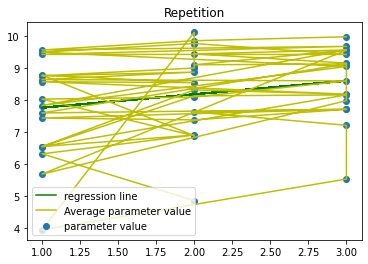

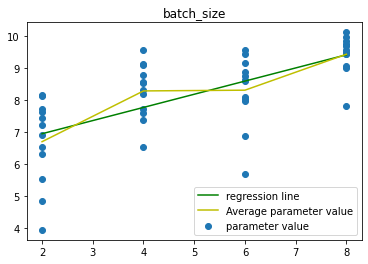

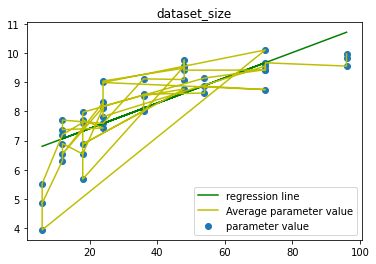

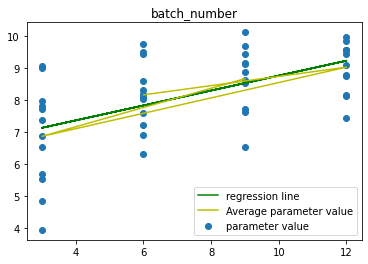

In [175]:
#question 1B we utilised sklearn to build regression models here we will incorporate the same
#methodology however we will utilise visualising our average calculation too
from sklearn.linear_model import LinearRegression

dsetResized_repetition_speed_lr= LinearRegression()
dsetResized_batchsize_speed_lr = LinearRegression()
dsetResized_datasize_speed_lr= LinearRegression()
dsetResized_batchnum_speed_lr = LinearRegression()

#Our we connect our dataframes with our linear regression framework
dsetResized_repetition_speed_lr.fit(df_dsetResized_repetition_speed[["repetition"]],df_dsetResized_repetition_speed["read_speed"])
dsetResized_batchsize_speed_lr.fit(df_dsetResized_batchsize_speed[["batch_size"]],df_dsetResized_batchsize_speed["read_speed"])
dsetResized_datasize_speed_lr.fit(df_dsetResized_datasize_speed[["dataset_size"]],df_dsetResized_datasize_speed["read_speed"])
dsetResized_batchnum_speed_lr.fit(df_dsetResized_batchnum_speed[["batch_number"]],df_dsetResized_batchnum_speed["read_speed"])

#Regression Slope
print("Slope")
print(dsetResized_repetition_speed_lr.coef_)
print(dsetResized_batchsize_speed_lr.coef_)
print(dsetResized_datasize_speed_lr.coef_)
print(dsetResized_batchnum_speed_lr.coef_)

#Regression intercept
print("Intercept")
print(dsetResized_repetition_speed_lr.intercept_)
print(dsetResized_batchsize_speed_lr.intercept_)
print(dsetResized_datasize_speed_lr.intercept_)
print(dsetResized_batchnum_speed_lr.intercept_)

print("P-Value")
dsetResized_repetition_speed_lr.score(df_dsetResized_repetition_speed[["repetition"]],df_dsetResized_repetition_speed["read_speed"])
dsetResized_batchsize_speed_lr.score(df_dsetResized_batchsize_speed[["batch_size"]],df_dsetResized_batchsize_speed["read_speed"])
dsetResized_datasize_speed_lr.score(df_dsetResized_datasize_speed[["dataset_size"]],df_dsetResized_datasize_speed["read_speed"])
dsetResized_batchnum_speed_lr.score(df_dsetResized_batchnum_speed[["batch_number"]],df_dsetResized_batchnum_speed["read_speed"])


#We now visualise using matplotlib
import matplotlib.pyplot as plt
repetition_readspeed_predict = dsetResized_repetition_speed_lr.predict(df_dsetResized_repetition_speed[["repetition"]])
plt.scatter(df_dsetResized_repetition_speed[["repetition"]],df_dsetResized_repetition_speed["read_speed"],label= "parameter value")
plt.plot(df_dsetResized_repetition_speed[["repetition"]],repetition_readspeed_predict, color="green",label = "regression line")
plt.plot(df_dsetResized_repetition_avgspeed[["repetition"]],df_dsetResized_repetition_avgspeed["read_speed"], label = "Average parameter value", color = "y")
plt.title("Repetition")
plt.legend(loc="lower left")
plt.show()

batchsize_readspeed_predict = dsetResized_batchsize_speed_lr.predict(df_dsetResized_batchsize_speed[['batch_size']])
plt.scatter(df_dsetResized_batchsize_speed[['batch_size']], df_dsetResized_batchsize_speed['read_speed'],label='parameter value')
plt.plot(df_dsetResized_batchsize_speed[['batch_size']], batchsize_readspeed_predict, color='green',label='regression line')
plt.plot(df_dsetResized_batchsize_avgspeed[['batch_size']],df_dsetResized_batchsize_avgspeed['read_speed'],label='Average parameter value', color='y')
plt.title('batch_size')
plt.legend(loc='lower right')
plt.show()


dataset_size_readspeed_predict = dsetResized_datasize_speed_lr.predict(df_dsetResized_datasize_speed[['dataset_size']])
plt.scatter(df_dsetResized_datasize_speed[['dataset_size']], df_dsetResized_datasize_speed['read_speed'],label='parameter value')
plt.plot(df_dsetResized_datasize_speed[['dataset_size']], dataset_size_readspeed_predict, color='green',label='regression line')
plt.plot(df_dsetResized_datasize_avgspeed[['dataset_size']],df_dsetResized_datasize_avgspeed['read_speed'], color='y',label='Average parameter value')
plt.title('dataset_size')
plt.legend(loc='lower right')
plt.show()


batch_number_readspeed_predict = dsetResized_batchnum_speed_lr.predict(df_dsetResized_batchnum_speed[['batch_number']])
plt.scatter(df_dsetResized_batchnum_speed[['batch_number']], df_dsetResized_batchnum_speed['read_speed'],label='parameter value')
plt.plot(df_dsetResized_batchnum_speed[['batch_number']], batch_number_readspeed_predict, color='green',label='regression line')
plt.plot(df_dsetResized_batchnum_avgspeed[['batch_number']],df_dsetResized_batchnum_avgspeed['read_speed'], color='y',label='Average parameter value')
plt.title('batch_number')
plt.legend(loc='lower right')
plt.show()




# Section 3: Machine Learning in the Cloud

In this section we will use the pre-processed data with the Google Cloud AI-Platform for Machine Learning. 

## Preparation: Machine Learning Setup

As in Section 1, in this section, we get started based on code from the 'Fast and Lean Data Science' course, this time lecture 4, to establish the task.

Switch to a runtime with a GPU before you run this section. You'll need to re-run section 0 and 1 up to (but not including) Task 1 after you switch runtimes to set everything up. 


### Create Train and Test Sets 

We will first **set up a few variables** for the machine learning. 

In [180]:
BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

Then we split the data into train and test sets.

In [181]:
# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
print("len(filenames): "+str(len(filenames)))
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


Then we split the train and validation sets into batches. 

In [182]:
def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

In [183]:
# just a little test to check the datasets
sample_set = training_dataset.take(4)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (64, 192, 192, 3), ['0', '0', '4', '1', '0', '2', '0', '1', '3', '4', '2', '1', '3', '1', '0', '2', '4', '3', '4', '1', '4', '0', '0', '4', '4', '1', '4', '4', '0', '3', '2', '3', '3', '3', '3', '1', '0', '1', '3', '4', '3', '1', '1', '4', '2', '4', '1', '3', '2', '3', '3', '0', '3', '3', '3', '2', '0', '4', '4', '1', '4', '1', '3', '1'])
Image batch shape (64, 192, 192, 3), ['4', '4', '2', '0', '2', '2', '4', '1', '3', '3', '3', '1', '4', '2', '3', '4', '1', '3', '2', '1', '0', '2', '3', '0', '2', '4', '1', '2', '4', '3', '2', '3', '3', '4', '3', '3', '1', '2', '1', '4', '4', '4', '0', '2', '3', '4', '2', '1', '1', '4', '0', '3', '0', '4', '4', '4', '1', '1', '4', '4', '1', '3', '3', '0'])
Image batch shape (64, 192, 192, 3), ['3', '0', '1', '3', '1', '4', '2', '0', '0', '0', '2', '4', '4', '4', '2', '3', '2', '3', '0', '4', '2', '4', '1', '2', '1', '0', '4', '0', '1', '1', '4', '0', '4', '2', '3', '4', '3', '3', '1', '4', '2', '3', '1', '1', '4', '2', '2', '1', '1',

### Set up a pretrained model

Here we load a **pre-trained model** and add a **fully connected** layer plus the **output layer**.
**Only** our **added layers** are **trained**, which lets us benefit from the trained model without the computation or data needed to re-train from scratch.

We use **MobileNetV2** here, which is a **relatively small and efficient** model. You can also try the larger ones, if you like. 

In [184]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dense (Dense)               (None, 100)               4608100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 6,866,589
Trainable params: 4,608,605
Non-tra

### Local Training

With **model and data**, we can now start the **training**. You can keep training time short by making sure that you use a runtime with GPU. You should also the number of epochs low, for initial tests. 
The **history** object keeps a record of the training progress.

In [185]:
tt0 = time.time()
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
tt = time.time() - tt0
print("Wall clock time = {}".format(tt))

Epoch 1/5
46/46 [==============================] - 18s 124ms/step - loss: 3.2470 - accuracy: 0.2534 - val_loss: 1.6005 - val_accuracy: 0.2438
Epoch 2/5
46/46 [==============================] - 2s 44ms/step - loss: 1.5923 - accuracy: 0.2531 - val_loss: 1.5869 - val_accuracy: 0.2391
Epoch 3/5
46/46 [==============================] - 2s 44ms/step - loss: 1.5696 - accuracy: 0.2639 - val_loss: 1.5462 - val_accuracy: 0.2719
Epoch 4/5
46/46 [==============================] - 2s 44ms/step - loss: 1.5489 - accuracy: 0.2738 - val_loss: 1.4986 - val_accuracy: 0.2641
Epoch 5/5
46/46 [==============================] - 2s 44ms/step - loss: 1.5080 - accuracy: 0.3043 - val_loss: 1.4954 - val_accuracy: 0.3562
Wall clock time = 44.04147934913635


As a result we have the printed training time, the trained model, and the history object, which we can visualise (not essential for us here).

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


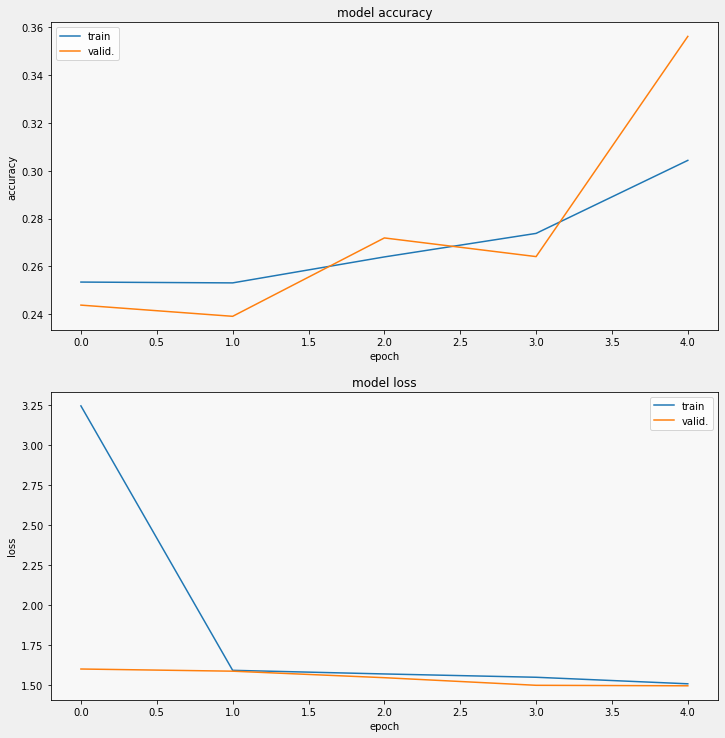

In [186]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

We can check a few examples with the predicted classes.

In [187]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

[b'tulips', b'dandelion', b'tulips', b'tulips', b'tulips', b'tulips', b'tulips', b'tulips', b'tulips']


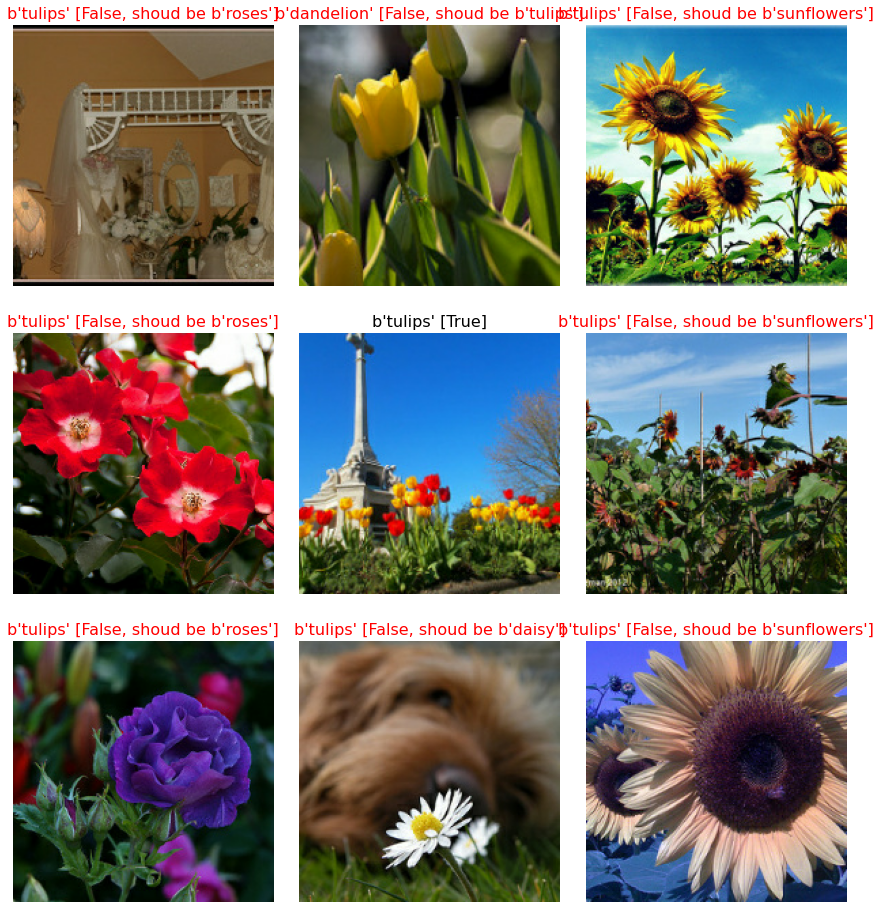

In [188]:
display_9_images_with_predictions(flowers, predictions, labels)

## Task 3: Machine learning in the cloud (20%)

Your task is now to **execute** the **training** in the **cloud** on the **AI-Platform** and experiment with different parallelisation approaches.


### 3a) Create the package and code for the AI-Platform (7%)

The AI Platform needs code in a '**package**'. 
The package can contain complex software systems and extensive  information on the setup. 
We will **keep** the package as **simple** as possible here.



i) The **minimal** 'package' in for AI-Platform needs a directory with **two modules** (i.e. Python files). 
Create a directory 'trainer' and then an empty file **`trainer/__init__.py`**. 
This can be done by using the **command line tool `touch`**. 
**Check** that the file **exists**. (1%) 

In [189]:

### CODING TASK ###
!mkdir trainer
!touch trainer/__init__.py
!ls -R

.:
2Aresults.pkl	2caddcache.py	maxcluster2bresults.pkl    trainer
2Asparkjob.py	2ccachejob.pkl	spark-2.4.8-bin-hadoop2.7
2caddcache.pkl	2ccachejob.py	spark_write_tfrec.py

./spark-2.4.8-bin-hadoop2.7:
bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin

./spark-2.4.8-bin-hadoop2.7/bin:
beeline		      pyspark		spark-class.cmd   spark-sql
beeline.cmd	      pyspark2.cmd	sparkR		  spark-sql2.cmd
docker-image-tool.sh  pyspark.cmd	sparkR2.cmd	  spark-sql.cmd
find-spark-home       run-example	sparkR.cmd	  spark-submit
find-spark-home.cmd   run-example.cmd	spark-shell	  spark-submit2.cmd
load-spark-env.cmd    spark-class	spark-shell2.cmd  spark-submit.cmd
load-spark-env.sh     spark-class2.cmd	spark-shell.cmd

./spark-2.4.8-bin-hadoop2.7/conf:
docker.properties.template  metrics.properties.template   spark-env.sh.template
fairscheduler.xml.template  slaves.template
log4j.properties.template   spark-defaults.conf.template

./spark

ii) The other file we need is the **module** with the **training code**, which we will call **`task.py`**. 

We can build this file by **combining** the **previous cells** under 'Machine Learning Setup' into one file, almost literally. 

Then, we need to **save the model itself** and the **training history** into a file after training. 
You can not pickle the `history` object returned by `model.fit`, but its **data in `history.history`** can be **pickled**. 
For **saving the model**, use `model.save()`.
In addition, **save** the measured **training time** and information about the **configuration** (should be passed as a parameter). 
Write the necessary code, like in section 2 when preparing jobs for Spark/Dataproc.

If you use **argparse** as in section 2 (recommended), then you need to **define an argument** `--job-dir` that will be passed through from the AI-Platform to your program when you define it.
(6%)

In [191]:
### CODING TASK ###
%%writefile trainer/task.py
### CODING TASK ###



import scipy.stats
import time
import datetime
import string
import random
import sys
import argparse
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
import pickle 
AUTO = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # this value is for testing. Increase later 
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
#GCS_TFR_PATTERN = 'gs://bd-cw-2-bucket/tfrecords-jpeg-192x192-2/flowers*.tfrec' 
TARGET_SIZE = [192,192]
VALIDATION_SPLIT = 0.25
#CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings
SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    image=image/255 #-we normalize our data    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames).shuffle(3670)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

def save(object,bucket,filename):
    with open(filename,mode='ab') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def cloud_machine_learning(argv):

    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file_history', metavar='out_file_history', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) 
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))
    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)

    


    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)
    tt1 = time.time() - tt0
    print("Wall clock time = {}".format(tt1))
    save(tt1,args.out_bucket,args.out_file_history)
    #model.summary()
    save(history.history, args.out_bucket, args.out_file)
    save(tt, args.out_bucket, args.out_file)
    model.save(BUCKET) # save model

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset= dataset.shuffle(3670)
  if train:
    
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) 
  y
  return dataset
  

if __name__ == "__main__":
    FILENAME = "cloudoneresult.pkl"
    PROJECT = "bdvk210033252"
    BUCKET = "gs://{}-storage".format(PROJECT)
    cloud_machine_learning(["--out_bucket",BUCKET,"--out_file_history",FILENAME])



Overwriting trainer/task.py


In [194]:
%%writefile trainer/task.py
### CODING TASK ###

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time, datetime
import argparse
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

AUTO = tf.data.experimental.AUTOTUNE 

PROJECT = 'bdvk210033252'
BUCKET = 'gs://{}-storage'.format(PROJECT)

BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # this value is for testing. Increase later 
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
#GCS_TFR_PATTERN = BUCKET + '/tfrecords-jpeg-192x192-2/flowers*.tfrec' 

TARGET_SIZE = [192,192]
VALIDATION_SPLIT = 0.25
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings
SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

def save(object,bucket,filename):
  with open(filename,mode='ab') as f:
      pickle.dump(object,f)
  print("Saving {} to {}".format(filename,bucket))
  import subprocess
  proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
  print("gstuil returned: " + str(proc.returncode))
  print(str(proc.stderr))

def deep_learning_ai_platform(argv):
  print(argv)
  parser = argparse.ArgumentParser() # get a parser object
  parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
  parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
  args = parser.parse_args(argv) # read the value

  # splitting data files between training and validation
  filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
  print("len(filenames): "+str(len(filenames)))
  split = int(len(filenames) * VALIDATION_SPLIT)
  training_filenames = filenames[split:]
  validation_filenames = filenames[:split]
  print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
  validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
  steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
  print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

  # instantiate the datasets
  training_dataset = get_batched_dataset(training_filenames, train=True)
  validation_dataset = get_batched_dataset(validation_filenames, train=False)

  pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
  pretrained_model.trainable = False

  model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()

  tt0 = time.time()
  history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=validation_dataset, validation_steps=validation_steps)
  tt = time.time() - tt0
  print("Wall clock time = {}".format(tt))

  save(history.history, args.out_bucket, args.out_file)
  save(tt, args.out_bucket, args.out_file)
  model.save(BUCKET) # save model

if __name__ == '__main__':
  FILENAME = 'cloudtworesult.pkl'
  PROJECT = 'bdvk210033252'
  BUCKET = 'gs://{}-storage'.format(PROJECT)
  deep_learning_ai_platform(["--out_bucket", BUCKET, "--out_file", FILENAME])


Overwriting trainer/task.py


### 3b) Run the Training on the AI-Platform and view the Output (3%)

Now, with all code in place, we can **submit the package as a job**. AI-Platform operation is **serverless**, therefore we do not need to create a cluster ourselves, but we just submit a job and the master and workers will be provided automatically. 
Find [here](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training) the information **how to submit a training job** in GCS AI-Platform.  

The **job** will wait in a **queue** for **some minutes** before it gets executed, this can take several minutes (at least on free credits). 
It's therefore a good idea to **test** the script **locally before** you submit to the **cloud**. 

You can get **powerful hardware** on AI-Platform. Up to 30 K80 or even P100 GPUs are available, but not all configurations are possible. 
Check [here](https://cloud.google.com/ai-platform/training/docs/quotas#gpu-quota) and [here](https://cloud.google.com/ai-platform/training/docs/using-gpus), and test [here on the console](https://console.cloud.google.com/ai-platform/create-job/custom-code?folder=true&organizationId=true) with the Create option whether your configuration works in the Google Cloud.

However, the machines with P100 and V100 GPUs are quite **expensive**. 
For the experiments here, the `standard_gpu` (1xK80) and the `complex_model_l_gpu` (8xK80) are sufficient.


In [ ]:
#1.	Standard machine Compute Engine machine name: n1-standard-4

In [196]:
# Lets try Standard GPU (1XK80)

# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_two" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 
!gcloud ai-platform jobs submit training $JOB_NAME \
  --package-path $TRAINER_PACKAGE_PATH/ \
  --module-name $MAIN_TRAINER_MODULE \
  --python-version 3.7 \
  --runtime-version 2.3 \
  --job-dir $JOB_DIR \
  --scale-tier custom \
  --master-machine-type standard_gpu \
  --stream-logs



Job [flowers_training_two] submitted successfully.
INFO	2022-05-04 08:37:46 +0000	service		Validating job requirements...
INFO	2022-05-04 08:37:46 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-04 08:37:47 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-04 08:37:47 +0000	service		Job flowers_training_two is queued.
INFO	2022-05-04 08:37:48 +0000	service		Waiting for training program to start.
NOTICE	2022-05-04 08:39:04 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-04 08:39:04 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-04 08:39:04 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-04 08:42:07 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["127.0.0.1:2222"]} --task={"type": "chief", "index": 0} --job={  "scale_tier": "CUSTOM",  "master_type": "standard_gpu",  "package_uris": ["gs://bdvk210033252-storage/jobs/flo

In [ ]:
##	complex_model_l_gpuCompute Engine machine name: n1-standard-32-k80x8 using only 1 master 8 x GPU K80 Batch size 128


In [ ]:
# Lets try GPU (8xK80)

# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_new" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 
!gcloud ai-platform jobs submit training $JOB_NAME \
  --package-path $TRAINER_PACKAGE_PATH/ \
  --module-name $MAIN_TRAINER_MODULE \
  --python-version 3.7 \
  --runtime-version 2.3 \
  --job-dir $JOB_DIR \
  --scale-tier custom \
  --master-machine-type complex_model_l_gpu \
  --stream-logs


Job [flowers_training_new] submitted successfully.
INFO	2022-05-02 17:48:19 +0000	service		Validating job requirements...
INFO	2022-05-02 17:48:19 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-02 17:48:19 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-02 17:48:19 +0000	service		Job flowers_training_new is queued.
INFO	2022-05-02 17:48:21 +0000	service		Waiting for training program to start.
NOTICE	2022-05-02 17:51:57 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-02 17:51:57 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-02 17:51:57 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-02 17:54:19 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["127.0.0.1:2222"]} --task={"type": "chief", "index": 0} --job={  "scale_tier": "CUSTOM",  "master_type": "complex_model_l_gpu",  "package_uris": ["gs://bdvk210033252-storage/j

Normally, gcloud returns immediately after job submission. If you want to keep track here, you can use the cell below. Usually, it is more practical to use the web interface https://console.cloud.google.com/ai-platform/jobs .

In [197]:
!gcloud ai-platform jobs stream-logs flowers_training_two

INFO	2022-05-04 08:37:46 +0000	service		Validating job requirements...
INFO	2022-05-04 08:37:46 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-04 08:37:47 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-04 08:37:47 +0000	service		Job flowers_training_two is queued.
INFO	2022-05-04 08:37:48 +0000	service		Waiting for training program to start.
NOTICE	2022-05-04 08:39:04 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-04 08:39:04 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-04 08:39:04 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-04 08:42:07 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["127.0.0.1:2222"]} --task={"type": "chief", "index": 0} --job={  "scale_tier": "CUSTOM",  "master_type": "standard_gpu",  "package_uris": ["gs://bdvk210033252-storage/jobs/flowers_training_two/packages/3cbf77569bae77a82f92d278

After training, **retrieve the history object and plot** the accuracy and loss curves based on the saved history to **check that the training worked**.

In [198]:
### CODING TASK ### 

!gsutil cp $BUCKET/cloudtworesult.pkl . 
with open("cloudtworesult.pkl",mode='rb') as f:
    model_history = pickle.load(f)
    total_timing = pickle.load(f)

Copying gs://bdvk210033252-storage/cloudtworesult.pkl...
/ [1 files][  280.0 B/  280.0 B]                                                
Operation completed over 1 objects/280.0 B.                                      


In [199]:
print(model_history)
print(total_timing)

{'loss': [3.494229316711426, 1.5592727661132812, 1.5293195247650146, 1.5077345371246338, 1.4346153736114502], 'accuracy': [0.2552083432674408, 0.2938988208770752, 0.3050595223903656, 0.3251488208770752, 0.3504464328289032], 'val_loss': [1.5616568326950073, 1.5588085651397705, 1.6052989959716797, 1.4640560150146484, 1.478529691696167], 'val_accuracy': [0.3046875, 0.3426339328289032, 0.2946428656578064, 0.3627232015132904, 0.3805803656578064]}
45.04713582992554


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


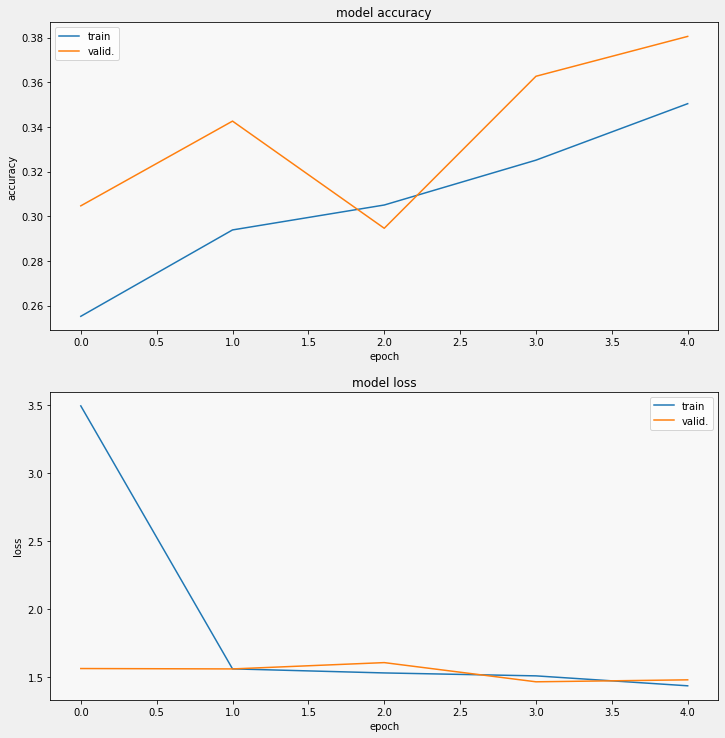

In [200]:
print(model_history.keys())
display_training_curves(model_history['accuracy'], model_history['val_accuracy'], 'accuracy', 211)
display_training_curves(model_history['loss'], model_history['val_loss'], 'loss', 212)

### 3c) Distributed learning	(10%)

Apply **distributed learning strategies** to the code (see https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras?hl=nb#choose_the_right_strategy for an example).  
Add the necessary changes to the code.

**Experiment** with **different strategies and batch sizes**. Report and interpret your results. 
For the defining cluster sizes, you can use command line options as described here: https://cloud.google.com/ai-platform/training/docs/machine-types#legacy-machine-types . 
Check the pricing here ( https://cloud.google.com/ai-platform/training/pricing ) and make sure everything works before you run jobs on the expensive configurations. 


In [209]:
### CODING TASK ### 

# Multi worker mirrored strategy - 1 master 8 K80 and 1 worker 8 K80

%%writefile trainer/task.py
### CODING TASK ###

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time, datetime
import argparse
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import json
import os

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

PROJECT = 'bdvk210033252'
BUCKET = 'gs://{}-storage'.format(PROJECT)

#BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # this value is for testing. Increase later 
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
#GCS_TFR_PATTERN = BUCKET + '/tfrecords-jpeg-192x192-2/flowers*.tfrec' 

TARGET_SIZE = [192,192]
VALIDATION_SPLIT = 0.25
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings
SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# Multi worker mirrored startegy
strategy = tf.distribute.MultiWorkerMirroredStrategy()

# Config dump - https://cloud.google.com/ai-platform/training/docs/distributed-training-details
tf_config_str = os.environ.get('TF_CONFIG')
tf_config_dict  = json.loads(tf_config_str)

# Convert back to string just for pretty printing
print(json.dumps(tf_config_dict, indent=2))

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # 
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) 
  
  return dataset
  #

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  
        "class": tf.io.FixedLenFeature([], tf.int64) #,   
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

def save(object,bucket,filename):
  with open(filename,mode='ab+') as f:
      pickle.dump(object,f)
  print("Saving {} to {}".format(filename,bucket))
  import subprocess
  proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
  print("gstuil returned: " + str(proc.returncode))
  print(str(proc.stderr))

def deep_learning_ai_platform(argv):
  print(argv)
  parser = argparse.ArgumentParser() # get a parser object
  parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
  parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
  args = parser.parse_args(argv) # read the value

  # splitting data files between training and validation
  filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
  print("len(filenames): "+str(len(filenames)))
  split = int(len(filenames) * VALIDATION_SPLIT)
  training_filenames = filenames[split:]
  validation_filenames = filenames[:split]
  print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
  validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
  steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
  print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

  # instantiate the datasets
  training_dataset = get_batched_dataset(training_filenames, train=True)
  validation_dataset = get_batched_dataset(validation_filenames, train=False)

  with strategy.scope():
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )     

  tt0 = time.time()
  history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=validation_dataset, validation_steps=validation_steps)
  tt = time.time() - tt0
  print("Wall clock time = {}".format(tt))
  print(history.history)

  save(history.history, args.out_bucket, args.out_file)
  save(tt, args.out_bucket, args.out_file)

if __name__ == '__main__':
  FILENAME = '3CA.pkl'
  PROJECT = 'bdvk210033252'
  BUCKET = 'gs://{}-storage'.format(PROJECT)
  deep_learning_ai_platform(["--out_bucket", BUCKET, "--out_file", FILENAME])

Overwriting trainer/task.py


In [ ]:
# 1.	Standard machine    Compute Engine machine name: n1-standard-4



In [202]:
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_3C2" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform local train \
    --job-dir $JOB_DIR  \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    -- --config standard_gpu --batch-size 32

Tensorflow version 2.8.0
2022-05-04 08:57:57.723640: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
{
  "job": {
    "job_name": "trainer.task",
    "args": [
      "--config",
      "standard_gpu",
      "--batch-size",
      "32",
      "--job-dir",
      "gs://bdvk210033252-storage/jobs/flowers_training_3C1"
    ]
  },
  "task": {},
  "cluster": {},
  "environment": "cloud"
}
['--out_bucket', 'gs://bdvk210033252-storage', '--out_file', '3CA.pkl']
len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 12 training files and 4 validation files
With a batch size of 128, there will be 21 batches per training epoch and 7 batch(es) per validation run.
Epoch 1/5
21/21 [==============================] - 13s 276ms/step - loss: 4.9362 - accuracy: 0.2344 - val_loss: 1.5918 - val_accuracy: 0.2422
Epoch 2/5
21/21 [========================

In [203]:
### CODING TASK ### 

!gsutil cp $BUCKET/3CA.pkl . 
with open("3CA.pkl",mode='rb+') as f:
  #f.seek(0)
  model_history = pickle.load(f)
  total_timing = pickle.load(f)

Copying gs://bdvk210033252-storage/3CA.pkl...
/ [1 files][  280.0 B/  280.0 B]                                                
Operation completed over 1 objects/280.0 B.                                      


In [204]:
print(model_history)
print(total_timing)

{'loss': [4.936178684234619, 1.5862878561019897, 1.5671141147613525, 1.5585088729858398, 1.524423360824585], 'accuracy': [0.234375, 0.2533482015132904, 0.255952388048172, 0.2566964328289032, 0.2886904776096344], 'val_loss': [1.5917755365371704, 1.5805692672729492, 1.5815191268920898, 1.54645836353302, 1.5252809524536133], 'val_accuracy': [0.2421875, 0.2466517835855484, 0.2466517835855484, 0.2421875, 0.3504464328289032]}
20.144162893295288


In [ ]:
# 1 MASTER 8 K80 GPU, 1 WORKER 8 K80 GPU, BATCH SIZE 128 - Batch size change made in code cell above

In [205]:

# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_3C2" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 
!gcloud ai-platform jobs submit training $JOB_NAME \
  --staging-bucket $PACKAGE_STAGING_PATH \
  --job-dir $JOB_DIR  \
  --region $REGION  \
  --package-path $TRAINER_PACKAGE_PATH \
  --module-name $MAIN_TRAINER_MODULE \
  --runtime-version 2.4 \
  --python-version 3.7 \
  --scale-tier custom \
  --master-machine-type complex_model_l_gpu \
  --worker-machine-type complex_model_l_gpu \
  --worker-count 1 \
  --stream-logs

Job [flowers_training_3C2] submitted successfully.
INFO	2022-05-04 09:00:40 +0000	service		Validating job requirements...
INFO	2022-05-04 09:00:40 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-04 09:00:41 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-04 09:00:41 +0000	service		Job flowers_training_3C2 is queued.
INFO	2022-05-04 09:04:27 +0000	service		Waiting for training program to start.
INFO	2022-05-04 09:04:33 +0000	service		Waiting for training program to start.
INFO	2022-05-04 09:04:34 +0000	service		Job is preparing.
NOTICE	2022-05-04 09:06:59 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-04 09:06:59 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-04 09:06:59 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-04 09:10:27 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["cmle-training-master-d6e7dd6373-0:222

In [207]:
### CODING TASK ### 

!gsutil cp $BUCKET/3CA.pkl . 
with open("3CA.pkl",mode='rb+') as f:
  #f.seek(0)
  model_history = pickle.load(f)
  total_timing = pickle.load(f)

Copying gs://bdvk210033252-storage/3CA.pkl...
/ [1 files][  280.0 B/  280.0 B]                                                
Operation completed over 1 objects/280.0 B.                                      


In [208]:
print(model_history)
print(total_timing)

{'loss': [4.166440486907959, 1.596897840499878, 1.5862764120101929, 1.5850121974945068, 1.5838650465011597], 'accuracy': [0.2306547611951828, 0.2641369104385376, 0.2663690447807312, 0.2659970223903656, 0.2652529776096344], 'val_loss': [1.6191397905349731, 1.6038058996200562, 1.600143313407898, 1.5969480276107788, 1.581504225730896], 'val_accuracy': [0.2511160671710968, 0.2466517835855484, 0.2488839328289032, 0.2455357164144516, 0.2611607015132904]}
59.14793038368225


In [ ]:
# Mirrored strategy - using only 1 master 8 x GPU K80

In [214]:
### CODING TASK ### 



%%writefile trainer/task.py
### CODING TASK ###

import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time, datetime
import argparse
# from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import json
import os

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

PROJECT = 'bdvk210033252'
BUCKET = 'gs://{}-storage'.format(PROJECT)

#BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # this value is for testing. Increase later 
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 


TARGET_SIZE = [192,192]
VALIDATION_SPLIT = 0.25
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings
SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# Mirrored startegy
strategy = tf.distribute.MirroredStrategy()

# Config dump - https://cloud.google.com/ai-platform/training/docs/distributed-training-details
tf_config_str = os.environ.get('TF_CONFIG')
tf_config_dict  = json.loads(tf_config_str)

# Convert back to string just for pretty printing
print(json.dumps(tf_config_dict, indent=2))

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
 

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord)
  return dataset

def save(object,bucket,filename):
  with open(filename,mode='ab+') as f:
      pickle.dump(object,f)
  print("Saving {} to {}".format(filename,bucket))
  import subprocess
  proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
  print("gstuil returned: " + str(proc.returncode))
  print(str(proc.stderr))

def deep_learning_ai_platform(argv):
  print(argv)
  parser = argparse.ArgumentParser() # get a parser object
  parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
  parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
  args = parser.parse_args(argv) # read the value

  # splitting data files between training and validation
  filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
  print("len(filenames): "+str(len(filenames)))
  split = int(len(filenames) * VALIDATION_SPLIT)
  training_filenames = filenames[split:]
  validation_filenames = filenames[:split]
  print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
  validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
  steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
  print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

  # instantiate the datasets
  training_dataset = get_batched_dataset(training_filenames, train=True)
  validation_dataset = get_batched_dataset(validation_filenames, train=False)

  with strategy.scope():
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )     

  tt0 = time.time()
  history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                      validation_data=validation_dataset, validation_steps=validation_steps)
  tt = time.time() - tt0
  print("Wall clock time = {}".format(tt))
  print(history.history)

  save(history.history, args.out_bucket, args.out_file)
  save(tt, args.out_bucket, args.out_file)

if __name__ == '__main__':
  FILENAME = '3CB.pkl'
  PROJECT = 'bdvk210033252'
  BUCKET = 'gs://{}-storage'.format(PROJECT)
  deep_learning_ai_platform(["--out_bucket", BUCKET, "--out_file", FILENAME])

Overwriting trainer/task.py


In [ ]:
# 1 MASTER 92atch size change made in code cell above

In [211]:
# 1 MASTER 92atch size change made in code cell above
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_3c3" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 
!gcloud ai-platform jobs submit training $JOB_NAME \
  --staging-bucket $PACKAGE_STAGING_PATH \
  --job-dir $JOB_DIR  \
  --region $REGION  \
  --package-path $TRAINER_PACKAGE_PATH \
  --module-name $MAIN_TRAINER_MODULE \
  --runtime-version 2.4 \
  --python-version 3.7 \
  --scale-tier custom \
  --master-machine-type complex_model_l_gpu \
  --stream-logs

Job [flowers_training_3c3] submitted successfully.
INFO	2022-05-04 09:26:44 +0000	service		Validating job requirements...
INFO	2022-05-04 09:26:45 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-04 09:26:45 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-04 09:26:45 +0000	service		Job flowers_training_3c3 is queued.
INFO	2022-05-04 09:26:48 +0000	service		Waiting for training program to start.
NOTICE	2022-05-04 09:30:14 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-04 09:30:14 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-04 09:30:14 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-04 09:32:37 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["127.0.0.1:2222"]} --task={"type": "chief", "index": 0} --job={  "scale_tier": "CUSTOM",  "master_type": "complex_model_l_gpu",  "package_uris": ["gs://bdvk210033252-storage/f

In [213]:
# 1 MASTER 8 K80 GPU, BATCH SIZE 64 - Batch size change made in code cell above
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_3C4" # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 
!gcloud ai-platform jobs submit training $JOB_NAME \
  --staging-bucket $PACKAGE_STAGING_PATH \
  --job-dir $JOB_DIR  \
  --region $REGION  \
  --package-path $TRAINER_PACKAGE_PATH \
  --module-name $MAIN_TRAINER_MODULE \
  --runtime-version 2.4 \
  --python-version 3.7 \
  --scale-tier custom \
  --master-machine-type complex_model_l_gpu \
  --stream-logs

Job [flowers_training_3C4] submitted successfully.
INFO	2022-05-04 09:41:11 +0000	service		Validating job requirements...
INFO	2022-05-04 09:41:12 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-04 09:41:12 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-04 09:41:13 +0000	service		Job flowers_training_3C4 is queued.
INFO	2022-05-04 09:41:13 +0000	service		Waiting for training program to start.
NOTICE	2022-05-04 09:44:20 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-04 09:44:20 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-04 09:44:20 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-04 09:47:25 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["127.0.0.1:2222"]} --task={"type": "chief", "index": 0} --job={  "scale_tier": "CUSTOM",  "master_type": "complex_model_l_gpu",  "package_uris": ["gs://bdvk210033252-storage/f

In [216]:
### CODING TASK ### 

!gsutil cp $BUCKET/3CB.pkl . 
with open("3CB.pkl",mode='rb+') as f:
  #f.seek(0)
  model_history = pickle.load(f)
  total_timing = pickle.load(f)

Copying gs://bdvk210033252-storage/3CB.pkl...
/ [1 files][  280.0 B/  280.0 B]                                                
Operation completed over 1 objects/280.0 B.                                      


In [217]:
print(model_history)
print(total_timing)

{'loss': [2.666565179824829, 1.6021194458007812, 1.602789044380188, 1.599843144416809, 1.5968270301818848], 'accuracy': [0.2209821492433548, 0.2511160671710968, 0.2563244104385376, 0.2526041567325592, 0.2604166567325592], 'val_loss': [1.608104944229126, 1.6049233675003052, 1.6054264307022095, 1.6002132892608643, 1.5869702100753784], 'val_accuracy': [0.2354910671710968, 0.2388392835855484, 0.2354910671710968, 0.2354910671710968, 0.2522321343421936]}
63.532864570617676


After you have run the experiments, copy the results over from the bucket to the local file system, so that you can extract the values for a **table** in your report together with a textual answer.

In [ ]:

# Attached in report

# Section 3. Theoretical discussion

## Task 4: Discussion in context. (20%)

In this task we refer to two ideas that are introduced in these two papers:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).
- Kahira, A.N. (2021). [An Oracle for Guiding Large-Scale Model/Hybrid Parallel Training of Convolutional Neural Networks](https://dl.acm.org/action/showLogin?redirectUri=%2Fdoi%2Fpdf%2F10.1145%2F3431379.3460644) In *Proceedings of the 30th International Symposium on High-Performance Parallel and Distributed Computing* (pp. 161-173). (Use the 'Institutional Login' link to get access with your City account.)


Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task. 
Kahira, A.N. (2021) introduce a model for predicting the effectivness of different parallelisation methods for  training neural networks. 

### 5a)	Contextualise

Relate the previous tasks and the results to these two concepts. (It is not necessary to work through the details of the papers, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply for this task? (10%)

### 5b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, on-line, stream) and discuss the general relationship with the two concepts above. (10%)

Provide the answers to these questions in your report. 


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit. 

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket 
!gsutil rb $BUCKET # delete the bucket